In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.mlab as mpll
import matplotlib as mpl
import glob
import os
plt.rcParams["font.family"] = "serif"
from scipy.stats import chi2
from scipy.integrate import cumulative_trapezoid
import pathlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import chi2_contingency
from scipy import signal as sp
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from scipy import stats as st
import statistics
import math
from scipy.interpolate import UnivariateSpline # para interpolar
from scipy.signal import find_peaks
!pip install svgwrite # install svgwrite module using pip


# 20/02 - Cobre


##Si los datos los subimos uno a uno

In [3]:
def cargar_datos_csv(archivo):
    data = pd.read_csv(archivo, skiprows=1, delimiter=",", decimal=".", header=None)
    tiempos = np.asarray(data[0])
    voltajes = np.asarray(data[1])
    return tiempos, voltajes

In [4]:
import os
print(os.listdir())  # Muestra los archivos en la carpeta actual


['.config', '7MedFotodiodo-conirisA13-50seg-L29-2cm0.csv', '6MedFotodiodo-conirisA13MASTIEMPOL13cm0.csv', '4MedFotodiodo-conirisA13MASTIEMPOL23-5cm0.csv', '5MedFotodiodo-conirisA13MASTIEMPOL17-7cm0.csv', '8MedFotodiodo-conirisA13-50seg-L41-5cm0.csv', '3MedFotodiodo-conirisA13MASTIEMPOL25-6cm0.csv', 'sample_data']


In [5]:
tiempo, voltaje = cargar_datos_csv("3MedFotodiodo-conirisA13MASTIEMPOL25-6cm0.csv")

## - Separo y escribo todo para el primer set de datos -

## Ajuste seno para tener una frecuencia aproximada
La idea es tomar un intervalo corto de tiempo de tal forma que el decaimiento no se aprecie. En este intervalo hacemos un ajuste sinosoidal y estimamos la frecuencia w

Frecuencia angular ajustada: 157067.1195 +- 3.1088 rad/s
Frecuencia en Hz: 24998.0085 +- 0.4948 Hz


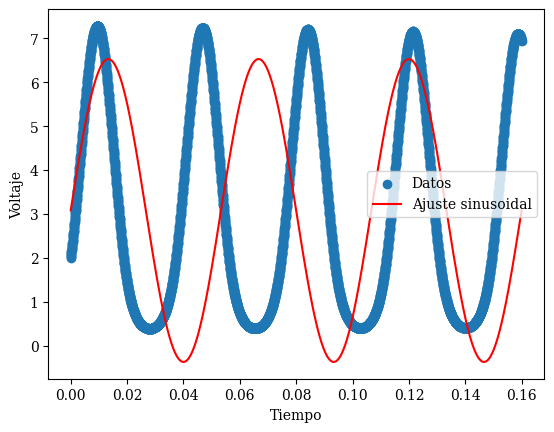

In [6]:
#primero ploteamos para ver que intervalo temporal tomamos:
#plt.plot(tiempo, voltaje)

#acortamos el intervalo
tiempo_sen = tiempo[46000:50000]
tiempo_sen = tiempo_sen - np.min(tiempo_sen)

voltaje_sen = voltaje[46000:50000]

plt.plot(tiempo_sen, voltaje_sen)

def sinusoidal(t, A, w, phi, C):
    return A * np.sin(w * t + phi) + C

# Valores iniciales aproximados para el ajuste
A0 = (max(voltaje_sen) - min(voltaje_sen)) / 2  # Amplitud inicial
w0 = 2 * np.pi / (tiempo_sen[1] - tiempo_sen[0])  # Frecuencia angular inicial aproximada
phi0 = 0  # Desfase inicial
C0 = np.mean(voltaje_sen)  # Offset inicial

popt, pcov = curve_fit(sinusoidal, tiempo_sen, voltaje_sen, p0=[A0, w0, phi0, C0], maxfev=5000)
A_opt, w_opt, phi_opt, C_opt = popt
w_error = np.sqrt(np.diag(pcov))[1]

f_opt = w_opt / (2 * np.pi)
error_f = w_error / (2 * np.pi)
print(f"Frecuencia angular ajustada: {w_opt:.4f} +- {w_error:.4f} rad/s")
print(f"Frecuencia en Hz: {f_opt:.4f} +- {error_f:.4f} Hz")

t_fit = np.linspace(min(tiempo_sen), max(tiempo_sen), 1000)
V_fit = sinusoidal(t_fit, *popt)

plt.scatter(tiempo_sen, voltaje_sen, label="Datos")
plt.plot(t_fit, V_fit, label="Ajuste sinusoidal", color="red")
plt.xlabel("Tiempo")
plt.ylabel("Voltaje")
plt.legend()
plt.show()


Frecuencia angular ajustada: 168.1056 +- 0.0925 rad/s
Frecuencia en Hz: 26.7548 +- 0.0147 Hz
Parámetro de decaimiento λ: 0.274948


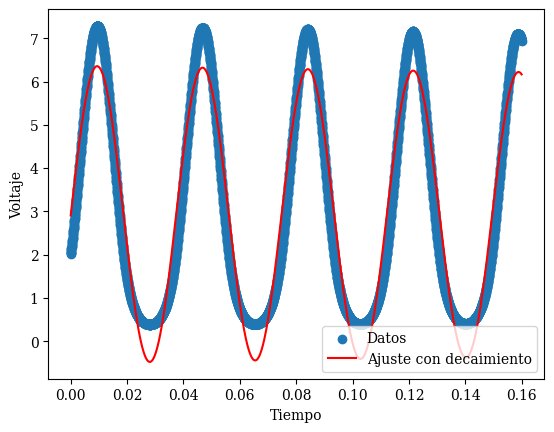

In [7]:
def sinusoidal_con_decaimiento(t, A, w, phi, C, lamb):
    return A * (1 / (1 + lamb * t)) * np.sin(w * t + phi) + C

# Seleccionamos un intervalo corto para minimizar el efecto del decaimiento
tiempo_sen = tiempo[46000:50000]
voltaje_sen = voltaje[46000:50000]

# Restamos el tiempo mínimo para mejorar la estabilidad numérica
tiempo_sen = tiempo_sen - np.min(tiempo_sen)

# Valores iniciales aproximados para el ajuste
A0 = (max(voltaje_sen) - min(voltaje_sen)) / 2  # Amplitud inicial
w0 = 2 * np.pi * 24.998  # Usamos la frecuencia obtenida por FFT
phi0 = 0  # Desfase inicial
C0 = np.mean(voltaje_sen)  # Offset inicial
lamb0 = 0.01  # Tasa de decaimiento inicial

# Ajuste de la curva
popt, pcov = curve_fit(sinusoidal_con_decaimiento, tiempo_sen, voltaje_sen,
                       p0=[A0, w0, phi0, C0, lamb0], maxfev=10000)

# Parámetros ajustados
A_opt, w_opt, phi_opt, C_opt, lamb_opt = popt
w_error = np.sqrt(np.diag(pcov))[1]

# Cálculo de frecuencia y su error
f_opt = w_opt / (2 * np.pi)
error_f = w_error / (2 * np.pi)

print(f"Frecuencia angular ajustada: {w_opt:.4f} +- {w_error:.4f} rad/s")
print(f"Frecuencia en Hz: {f_opt:.4f} +- {error_f:.4f} Hz")
print(f"Parámetro de decaimiento λ: {lamb_opt:.6f}")

# Generamos datos ajustados para la gráfica
t_fit = np.linspace(min(tiempo_sen), max(tiempo_sen), 1000)
V_fit = sinusoidal_con_decaimiento(t_fit, *popt)

# Gráfica
plt.scatter(tiempo_sen, voltaje_sen, label="Datos")
plt.plot(t_fit, V_fit, label="Ajuste con decaimiento", color="red")
plt.xlabel("Tiempo")
plt.ylabel("Voltaje")
plt.legend()
plt.show()

In [8]:
from scipy.fft import fft, fftfreq

# Realizamos la FFT para encontrar la frecuencia dominante
N = len(tiempo_sen)
dt = np.mean(np.diff(tiempo_sen))  # Paso temporal
frecuencias = fftfreq(N, d=dt)  # Eje de frecuencias
espectro = np.abs(fft(voltaje_sen))  # Magnitud de la FFT

# Encontramos el pico de la frecuencia dominante
idx_frec = np.argmax(espectro[1:]) + 1  # Omitimos el componente DC
frecuencia_dominante = abs(frecuencias[idx_frec])
w0 = 2 * np.pi * frecuencia_dominante

print(f"Frecuencia estimada por FFT: {frecuencia_dominante:.4f} Hz")


Frecuencia estimada por FFT: 24.9980 Hz


## Decaimiento de la señal

Encuentro los picos de la señal

In [9]:
#calculo error daq

def calculate_absolute_accuracy(reading):
    # Example values from the table for the 10V range
    range_value = 10  # Nominal range positive full scale
    residual_gain_error = 75*(10**-6)  # ppm of reading
    gain_tempoo = 7.3*(10**-6)  # ppm/°C
    temp_change_internal_cal = 5  # Example temperature change in °C
    reference_tempoo = 5*(10**-6)  # ppm/°C
    temp_change_external_cal = 5  # Example temperature change in °C
    residual_offset_error = 20*(10**-6)  # ppm of range
    offset_tempoo = 34*(10**-6)  # ppm of range/°C
    inl_error = 76*(10**-6)  # ppm of range
    random_noise = 295*(10**-6)  # µVrms

    # Calculate GainError
    #gain_error = residual_gain_error + gain_tempoo * temp_change_internal_cal + reference_tempoo * temp_change_external_cal
    gain_error = residual_gain_error + gain_tempoo * temp_change_internal_cal + reference_tempoo * temp_change_external_cal

    # Calculate OffsetError
    offset_error = residual_offset_error + offset_tempoo * temp_change_internal_cal + inl_error

    # Calculate NoiseUncertainty
    noise_uncertainty = (random_noise * 3) / 100

    # Calculate Absolute Accuracy
    absolute_accuracy = reading * gain_error + range_value * offset_error + noise_uncertainty

    return absolute_accuracy

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


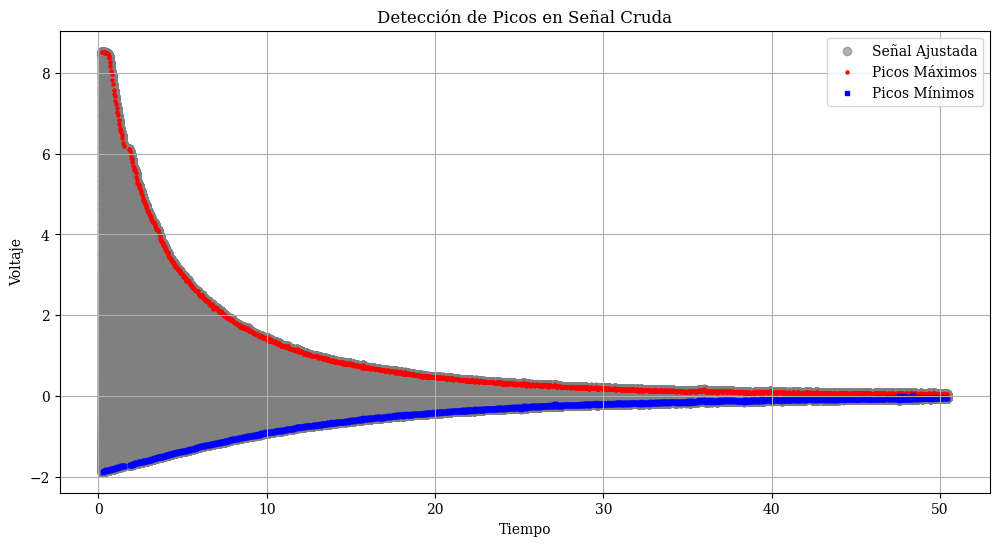

In [10]:
num_puntos_finales = 2000  # Ajusta según tu señal
offset = np.mean(voltaje[-num_puntos_finales:])
V_ajustada = voltaje - offset # Restar el offset para que al final la señal quede en 0

peaks_max, _ = find_peaks(V_ajustada, height=0.001, distance=10, prominence=0.05)
peaks_min, _ = find_peaks(-V_ajustada, prominence=0.001, distance=5, width=40)

#Crear listas con los valores de los picos
t_max = tiempo[peaks_max]
V_max = V_ajustada[peaks_max]

t_min = tiempo[peaks_min]
V_min = V_ajustada[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
#plt.scatter(tiempo, voltaje, label="Señal Ajustada", color='gray', alpha=0.6)
plt.scatter(tiempo, V_ajustada, label="Señal Ajustada", color='gray', alpha=0.6)
plt.scatter(t_max, V_max, label='Picos Máximos', color='red', marker='o', s=5)
plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', marker='s', s=5)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
#plt.xlim(30.4,30.5)
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

Ajuste exponencial de los Picos

Ajuste para picos máximos:
A = 8.3124, α = 0.1967 +- 0.0010, C = 0.1665
Chi-cuadrado (χ²): 3268656.8040
Chi-cuadrado reducido (χ²/ν): 2280.9887
p-valor: 0.0000


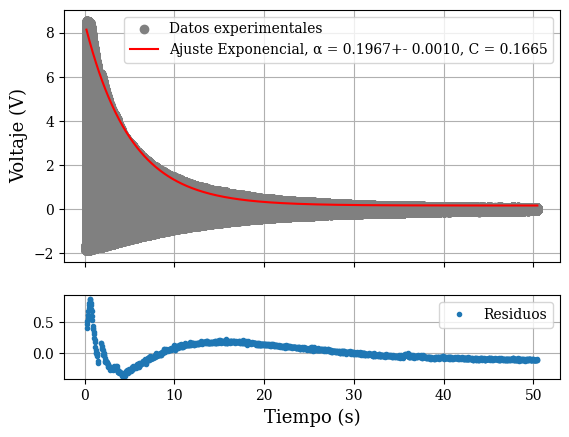


Ajuste para picos mínimos:
A = -1.9644, α = 0.0782+- 0.0002, C = -0.0062
Chi-cuadrado (χ²): 56714.1968
Chi-cuadrado reducido (χ²/ν): 35.4685
p-valor: 0.0000


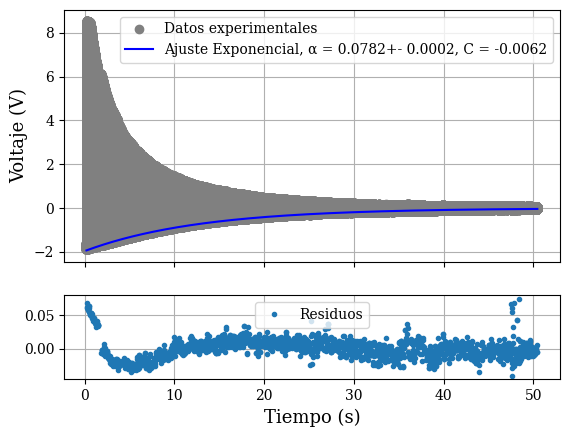

alfa 0.13743041653730853


In [11]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit = np.linspace(min(tiempo), max(tiempo), 1000)

#----------Máximos-----------
errorVmax = calculate_absolute_accuracy(V_max)
popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)
V_fit_max = exponencial(t_fit, *popt_max)
erroralfa_max = np.sqrt(np.diag(pcov_max))[1]

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

alfamax = popt_max[1]

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {alfamax:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, V_ajustada,'o', label='Datos experimentales', color="grey")
ax[0].plot(t_fit, V_fit_max, 'r-', label=f'Ajuste Exponencial, α = {popt_max[1]:.4f}+- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}')
ax[1].errorbar(t_max, residuos, fmt=".", label="Residuos")
ax[1].set_xlabel('Tiempo (s)', fontsize=13)
ax[0].set_ylabel('Voltaje (V)', fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()

#----------Mínimos-----------
errorVmin = calculate_absolute_accuracy(V_min)
popt_min, pcov_min = curve_fit(exponencial, t_min, V_min, p0=[min(V_min), 0.1, max(V_min)], sigma=errorVmin)


V_fit_min = exponencial(t_fit, *popt_min)
erroralfa_min = np.sqrt(np.diag(pcov_min))[1]

# Predicción y residuos
y_predicho = exponencial(t_min, *popt_min)
residuos = V_min - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmin) ** 2)
dof = len(t_min) - len(popt_min)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

alfamin = popt_min[1]
#Resultados
print("\nAjuste para picos mínimos:")
print(f"A = {popt_min[0]:.4f}, α = {alfamin:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, V_ajustada, 'o', label='Datos experimentales', color="grey")
ax[0].plot(t_fit, V_fit_min, label=f'Ajuste Exponencial, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}', color="blue")
ax[1].errorbar(t_min, residuos, fmt=".", label="Residuos")
ax[1].set_xlabel('Tiempo (s)', fontsize=13)
ax[0].set_ylabel('Voltaje (V)', fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()
print("alfa", (alfamax+alfamin)/2)

alfa 0.19666994557654582
Ajuste para picos máximos:
A = 8.3124, α = 0.1967 +- 0.0010, C = 0.1665
Chi-cuadrado (χ²): 3268656.8040
Chi-cuadrado reducido (χ²/ν): 2280.9887
p-valor: 0.0000


<ipython-input-12-05055ac5df18>:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1[1].legend()


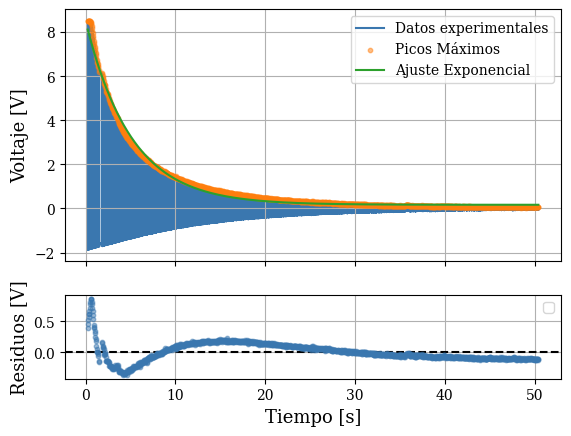

In [12]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit_max1 = np.linspace(min(t_max), max(t_max), 1000)

"""
C_init_max = np.mean(V_max[int(len(V_max) * 0.8):])

A_init_max = np.max(V_max) - C_init_max

popt_max, pcov_max = curve_fit(
    exponencial, t_max, V_max,
    p0=[A_init_max, 0.5, C_init_max],
    absolute_sigma=True
)
"""
popt_max, pcov_max = curve_fit(
    exponencial, t_max, V_max,
    p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)

V_fit_max1 = exponencial(t_fit_max1, *popt_max)

residuos_max = V_max - exponencial(t_max, *popt_max)

fig1, ax1 = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1[0].plot(tiempo, V_ajustada, color="#3a77af", label='Datos experimentales', zorder=1)
ax1[0].scatter(t_max, V_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax1[0].plot(t_fit_max1, V_fit_max1, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax1[0].set_ylabel('Voltaje [V]', fontsize=13)
ax1[0].grid()
ax1[0].legend()

ax1[1].axhline(0, color='black', linestyle='--')
ax1[1].scatter(t_max, residuos_max, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax1[1].set_xlabel('Tiempo [s]', fontsize=13)
ax1[1].set_ylabel('Residuos [V]', fontsize=13)
ax1[1].grid()
ax1[1].legend()

print("alfa", popt_max[1])

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

## Fourier

In [13]:
def calcular_transformada_fourier(tiempo, voltaje):
    # Número de puntos
    N = len(tiempo)

    # Espaciado en el tiempo
    dt = tiempo[1] - tiempo[0]

    # Eliminar el componente de DC (restar la media)
    voltaje_sin_dc = voltaje - np.mean(voltaje)

    # Calculamos la Transformada de Fourier
    fft_result = np.fft.fft(voltaje_sin_dc)

    # Frecuencias correspondientes
    frecuencias = np.fft.fftfreq(N, dt)

    # Solo nos interesan las frecuencias positivas
    frecuencias_positivas = frecuencias[:N//2]
    fft_positivo = 2.0/N * np.abs(fft_result[:N//2])

    return frecuencias_positivas, fft_positivo

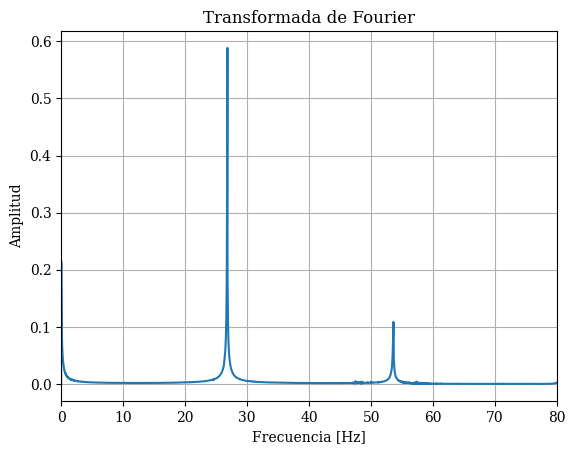

Frecuencia dominante: 26.819455998050174 Hz
Amplitud dominante: 0.5884686676419317 V


In [14]:
frecuencias, fft_resultado = calcular_transformada_fourier(tiempo, V_ajustada)

# Graficar el resultado
plt.figure()
plt.plot(frecuencias, fft_resultado)
plt.title('Transformada de Fourier')
plt.xlabel('Frecuencia [Hz]')
plt.xlim(0, 80)
plt.ylabel('Amplitud')
plt.grid()
plt.show()

#OBS: la amplitud puede parecer rara que este tan baja pero es porque le reste la media así quedaba en 0

# Encontrar la frecuencia dominante y su amplitud
indice_frecuencia_dominante = np.argmax(fft_resultado)
frecuencia_dominante = frecuencias[indice_frecuencia_dominante]
amplitud_dominante = fft_resultado[indice_frecuencia_dominante]

print(f"Frecuencia dominante: {frecuencia_dominante} Hz")
print(f"Amplitud dominante: {amplitud_dominante} V")

In [15]:
#asumimos que es completamente cobre
alfa = (alfamax+alfamin)/2
d = 0.5/100 # en metros
rho = 8960 * (np.pi * (d / 2) ** 2)  #del cobre
I = (np.pi * (d)**4)/64
L = 25.6/100 #en metros
k = 1.875/L
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print("El modulo de Young es de:", E/10**9)



El modulo de Young es de: 56.58518121926757


In [16]:
# NO asumimos que es completamente cobre
alfa = (alfamax+alfamin)/2
d = 0.5/100 # en metros
rho = (77/1000)*(1/(25.6/100))  #del cobre
I = (np.pi * (d)**4)/64
L = 25.6/100 #en metros
k = 1.875/L
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print("El modulo de Young es de:", E/10**9)

El modulo de Young es de: 96.74211353981278


In [17]:
!pip install uncertainties
L_err = 0.001
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 25000/len(frecuencias) # frec de meustreo/numero de puntos de la fft
alpha_err = 0.005 # sale de la matriz de covarianza
from uncertainties import ufloat

alfa_u = ufloat((alfamax+alfamin)/2, alpha_err)
d_u = ufloat(0.5/100, d_err)
rho_u = ufloat((77/1000)*(1/(25.6/100)), rho_err)
L_u = ufloat(25.6/100, L_err)
f_u = ufloat(frecuencia_dominante, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + ((alfamax+alfamin)/2)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.3 MB/s eta 0:00:00


96.74211353981278+/-1.7258881954509948

##Ahora sí por medición

##Medición 4

In [18]:
tiempo, voltaje = cargar_datos_csv("4MedFotodiodo-conirisA13MASTIEMPOL23-5cm0.csv")

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


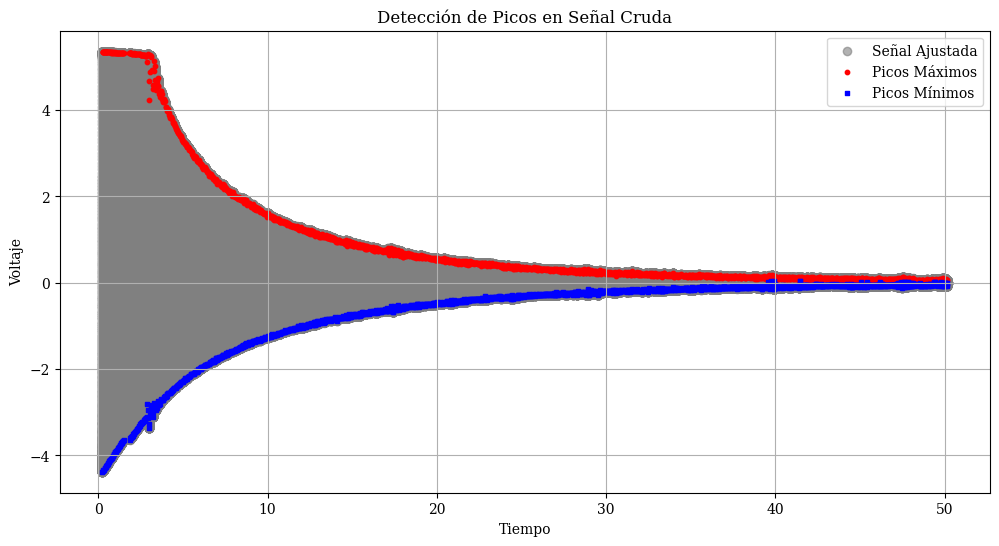

In [19]:
num_puntos_finales = 2000  # Ajusta según tu señal
offset = np.mean(voltaje[-num_puntos_finales:])
V_ajustada = voltaje - offset # Restar el offset para que al final la señal quede en 0

peaks_max, _ = find_peaks(V_ajustada, height=0.001, distance=10, prominence=0.05)
peaks_min, _ = find_peaks(-V_ajustada, prominence=0.001, distance=5, width=40)

#Crear listas con los valores de los picos
t_max = tiempo[peaks_max]
V_max = V_ajustada[peaks_max]

t_min = tiempo[peaks_min]
V_min = V_ajustada[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.scatter(tiempo, V_ajustada, label="Señal Ajustada", color='gray', alpha=0.6)
plt.scatter(t_max, V_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

Ajuste para picos máximos:
A = 6.3698, α = 0.1367 +- 0.0009, C = 0.0961
Chi-cuadrado (χ²): 2364.8007
Chi-cuadrado reducido (χ²/ν): 1.4384
p-valor: 0.0000


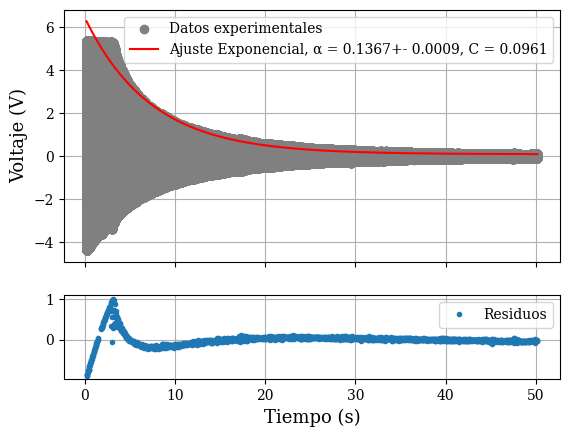


Ajuste para picos mínimos:
A = -4.3047, α = 0.1271+- 0.0004, C = -0.0819
Chi-cuadrado (χ²): 607.4564
Chi-cuadrado reducido (χ²/ν): 0.3307
p-valor: 1.0000


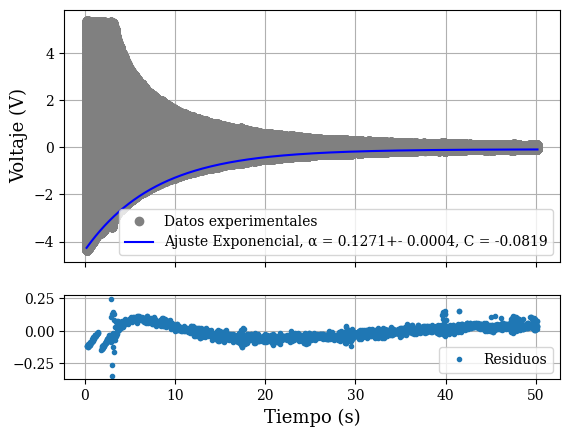

In [20]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit = np.linspace(min(tiempo), max(tiempo), 1000)

errorVmax = np.maximum(calculate_absolute_accuracy(V_max), np.std(V_max)/10)  # Evitar incertidumbres subestimadas
errorVmin = np.maximum(calculate_absolute_accuracy(V_min), np.std(V_min)/10)

#----------Máximos-----------
popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)
V_fit_max = exponencial(t_fit, *popt_max)
erroralfa_max = np.sqrt(np.diag(pcov_max))[1]

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, V_ajustada,'o', label='Datos experimentales', color="grey")
ax[0].plot(t_fit, V_fit_max, 'r-', label=f'Ajuste Exponencial, α = {popt_max[1]:.4f}+- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}')
ax[1].errorbar(t_max, residuos, fmt=".", label="Residuos")
ax[1].set_xlabel('Tiempo (s)', fontsize=13)
ax[0].set_ylabel('Voltaje (V)', fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()

#----------Mínimos-----------
popt_min, pcov_min = curve_fit(exponencial, t_min, V_min, p0=[min(V_min), 0.1, max(V_min)],sigma=errorVmin)

V_fit_min = exponencial(t_fit, *popt_min)
erroralfa_min = np.sqrt(np.diag(pcov_min))[1]

# Predicción y residuos
y_predicho = exponencial(t_min, *popt_min)
residuos = V_min - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmin) ** 2)
dof = len(t_min) - len(popt_min)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

#Resultados
print("\nAjuste para picos mínimos:")
print(f"A = {popt_min[0]:.4f}, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, V_ajustada, 'o', label='Datos experimentales', color="grey")
ax[0].plot(t_fit, V_fit_min, label=f'Ajuste Exponencial, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}', color="blue")
ax[1].errorbar(t_min, residuos, fmt=".", label="Residuos")
ax[1].set_xlabel('Tiempo (s)', fontsize=13)
ax[0].set_ylabel('Voltaje (V)', fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()

<ipython-input-21-a50360db70fd>:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1[1].legend()


alfa 0.13670516018601842
Ajuste para picos máximos:
A = 6.3698, α = 0.1367 +- 0.0009, C = 0.0961
Chi-cuadrado (χ²): 2364.8007
Chi-cuadrado reducido (χ²/ν): 1.4384
p-valor: 0.0000


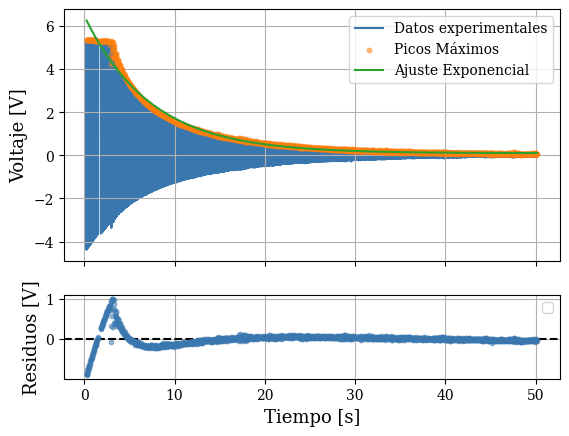

In [21]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit_max2 = np.linspace(min(t_max), max(t_max), 1000)

"""
C_init_max = np.mean(V_max[int(len(V_max) * 0.8):])

A_init_max = np.max(V_max) - C_init_max

popt_max, pcov_max = curve_fit(
    exponencial, t_max, V_max,
    p0=[A_init_max, 0.5, C_init_max],
    absolute_sigma=True
)
"""
popt_max, pcov_max = curve_fit(
    exponencial, t_max, V_max,
    p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)

V_fit_max2 = exponencial(t_fit_max2, *popt_max)

residuos_max = V_max - exponencial(t_max, *popt_max)

fig1, ax1 = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1[0].plot(tiempo, V_ajustada, color="#3a77af", label='Datos experimentales', zorder=1)
ax1[0].scatter(t_max, V_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax1[0].plot(t_fit_max2, V_fit_max2, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax1[0].set_ylabel('Voltaje [V]', fontsize=13)
ax1[0].grid()
ax1[0].legend()

ax1[1].axhline(0, color='black', linestyle='--')
ax1[1].scatter(t_max, residuos_max, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax1[1].set_xlabel('Tiempo [s]', fontsize=13)
ax1[1].set_ylabel('Residuos [V]', fontsize=13)
ax1[1].grid()
ax1[1].legend()

print("alfa", popt_max[1])

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

Frecuencia estimada: 31.25 Hz


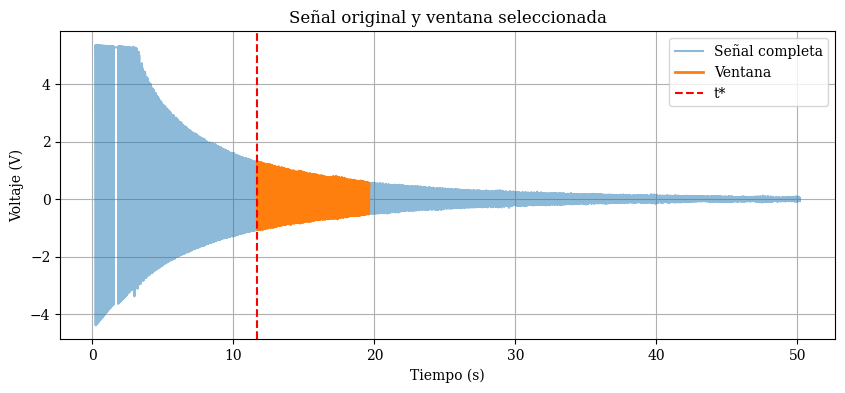

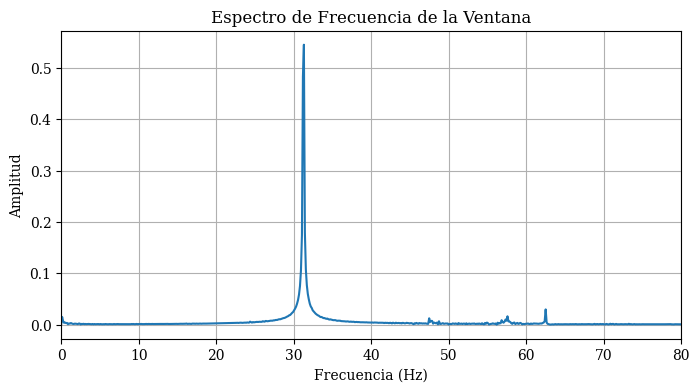

In [22]:
#Codigo para tomar N periodos
# Determinar t* donde la señal ha decaído al 10% de la inicial
t_star = -np.log(0.1) / alfamax

# Aplicar FFT a toda la señal para estimar la frecuencia dominante
frecuencias, fft_resultado = calcular_transformada_fourier(tiempo, V_ajustada)

# Encontrar la frecuencia dominante
indice_frecuencia_dominante = np.argmax(fft_resultado)
f_estimada = frecuencias[indice_frecuencia_dominante]  # Usamos la frecuencia dominante estimada

print(f"Frecuencia estimada: {f_estimada:.2f} Hz")

# Seleccionar N períodos desde t*
N = 250
T = 1 / f_estimada
idx_start = np.searchsorted(tiempo, t_star)
idx_end = idx_start + int(N * T * (len(tiempo) / max(tiempo)))  # Ajustamos por la resolución temporal

ventana = V_ajustada[idx_start:idx_end]
t_ventana = tiempo[idx_start:idx_end]

# Aplicar FFT sobre la ventana seleccionada
frecuencias_ventana, fft_resultado_ventana = calcular_transformada_fourier(t_ventana, ventana)

# Graficar la señal original y la ventana seleccionada
plt.figure(figsize=(10, 4))
plt.plot(tiempo, V_ajustada, label="Señal completa", alpha=0.5)
plt.plot(t_ventana, ventana, label=f"Ventana", linewidth=2)
plt.axvline(t_star, color='r', linestyle='--', label="t*")
plt.legend()
plt.xlabel("Tiempo (s)")
plt.ylabel("Voltaje (V)")
plt.title("Señal original y ventana seleccionada")
plt.grid()
plt.show()

# Graficar la FFT de la ventana
plt.figure(figsize=(8, 4))
plt.plot(frecuencias_ventana, fft_resultado_ventana)
plt.xlabel("Frecuencia (Hz)")
plt.xlim(0,80)
plt.ylabel("Amplitud")
plt.title("Espectro de Frecuencia de la Ventana")
plt.grid()
plt.show()

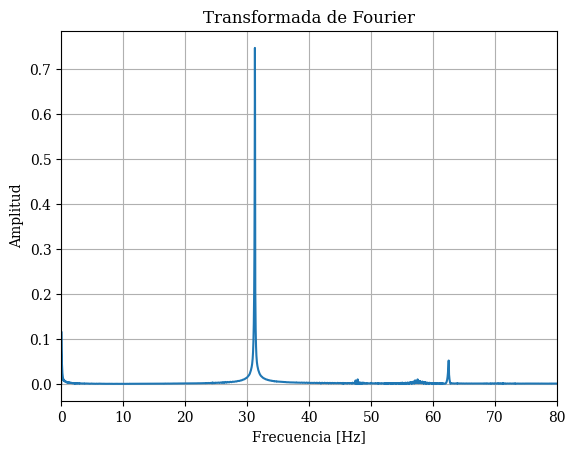

Frecuencia dominante: 31.251890702929625 Hz
Amplitud dominante: 0.7464592806046793 V


In [23]:
frecuencias, fft_resultado = calcular_transformada_fourier(tiempo, voltaje)

# Graficar el resultado
plt.figure()
plt.plot(frecuencias, fft_resultado)
plt.title('Transformada de Fourier')
plt.xlabel('Frecuencia [Hz]')
plt.xlim(0, 80)
plt.ylabel('Amplitud')
plt.grid()
plt.show()

#OBS: la amplitud puede parecer rara que este tan baja pero es porque le reste la media así quedaba en 0

# Encontrar la frecuencia dominante y su amplitud
indice_frecuencia_dominante = np.argmax(fft_resultado)
frecuencia_dominante = frecuencias[indice_frecuencia_dominante]
amplitud_dominante = fft_resultado[indice_frecuencia_dominante]

print(f"Frecuencia dominante: {frecuencia_dominante} Hz")
print(f"Amplitud dominante: {amplitud_dominante} V")

In [24]:
alfa = (alfamax+alfamin)*0.5
d = 0.5/100 # en metros
rho = 8960 * (np.pi * (d / 2) ** 2)  #del cobre
I = (np.pi * (d)**4)/64
L = 23.5/100 #en metros
k = 1.875/L
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print("El modulo de Young es de:", E/10**9)
print("rho", rho)
print("I", I)
print("k", k)

El modulo de Young es de: 54.559061037644966
rho 0.1759291886010284
I 3.067961575771282e-11
k 7.9787234042553195


In [25]:
# NO asumimos que es completamente cobre
alfa = 0.135
d = 0.5/100 # en metros
rho = (77/1000)*(1/(23.5/100))  #del cobre
I = (np.pi * (d)**4)/64
L = 23.5/100 #en metros
k = 1.875/L
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print("El modulo de Young es de:", E/10**9)

El modulo de Young es de: 101.61360123436677


In [26]:
L_err = 0.001
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 25000/len(frecuencias) # frec de meustreo/numero de puntos de la fft
alpha_err = 0.005 # sale de la matriz de covarianza
from uncertainties import ufloat

alfa_u = ufloat((alfamax+alfamin)/2, alpha_err)
d_u = ufloat(0.5/100, d_err)
rho_u = ufloat((77/1000)*(1/(23.5/100)), rho_err)
L_u = ufloat(23.5/100, L_err)
f_u = ufloat(frecuencia_dominante, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + ((alfamax+alfamin)/2)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u

101.61360297928715+/-1.9316774778612251

##Medición 5

In [27]:
tiempo, voltaje = cargar_datos_csv("5MedFotodiodo-conirisA13MASTIEMPOL17-7cm0.csv")

<ipython-input-28-2c2c1ed9b416>:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('señaloriginalsinofset.png', format='png')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


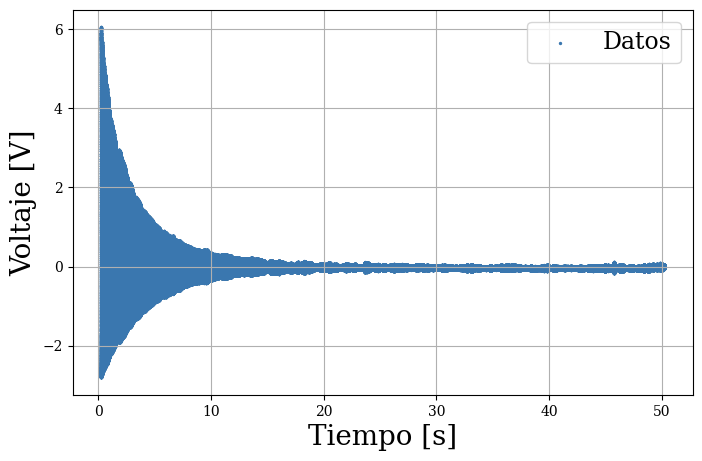

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

"\nplt.scatter(tiempo, voltaje-np.mean(voltaje), label='Datos', color='#3a77af', s=1)\nplt.xlim(10, 10.1)\nplt.ylim(-0.4, 0.4)\nplt.grid()\nplt.savefig('zoom.png', format='png')\nplt.show()\n# Descargar el archivo a tu compu\nfrom google.colab import files\nfiles.download('zoom.png')\n"

In [28]:
plt.figure(figsize=(8, 5))

plt.scatter(tiempo, voltaje-np.mean(voltaje), label='Datos', color='#3a77af', s=2)
plt.xlabel('Tiempo [s]', fontsize=20)
plt.ylabel('Voltaje [V]', fontsize=20)
plt.grid()
plt.legend(fontsize=17)
plt.savefig('señaloriginalsinofset.png', format='png')
plt.show()
# Descargar el archivo a tu compu
from google.colab import files
files.download('señaloriginalsinofset.png')

"""
plt.scatter(tiempo, voltaje-np.mean(voltaje), label='Datos', color='#3a77af', s=1)
plt.xlim(10, 10.1)
plt.ylim(-0.4, 0.4)
plt.grid()
plt.savefig('zoom.png', format='png')
plt.show()
# Descargar el archivo a tu compu
from google.colab import files
files.download('zoom.png')
"""

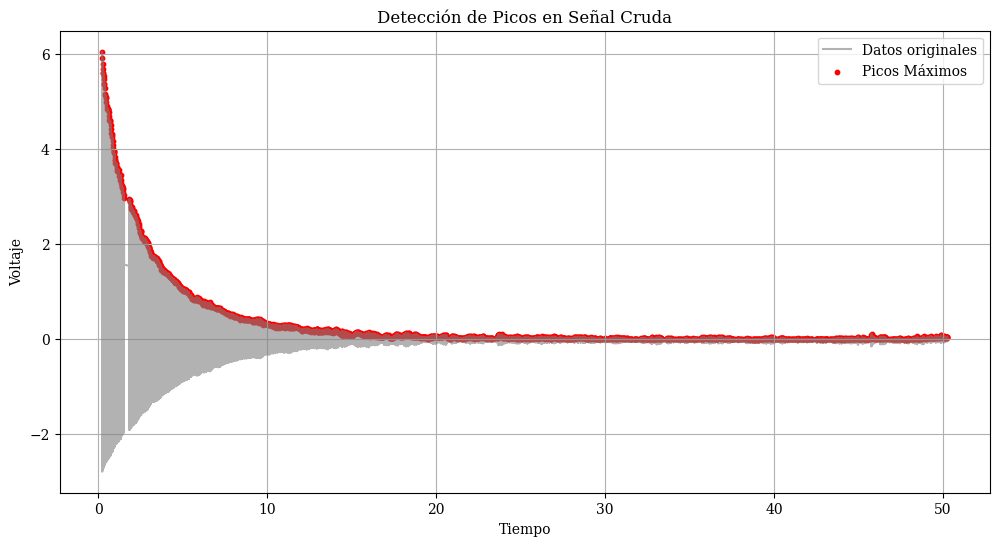

In [29]:
#Encontrar picos máximos
voltaje = voltaje - np.mean(voltaje) #centramos en 0
peaks_max, _ = find_peaks(voltaje, prominence=0.05)
#peaks_min, _ = find_peaks(-voltaje, prominence=0.05)# Para mínimos, buscamos picos en la señal invertida

#Crear listas con los valores de los picos
t_max = tiempo[peaks_max]
V_max = voltaje[peaks_max]
"""
t_min = tiempo[peaks_min]
V_min = voltaje[peaks_min]
"""
#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(tiempo, voltaje, label='Datos originales', color='gray', alpha=0.6)
plt.scatter(t_max, V_max, label='Picos Máximos', color='red', marker='o', s=10)
#plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

2425
2425
Chi-cuadrado reducido vol 2: 1.0552
Ajuste para picos máximos:
A = 5.5949, α = 0.3438 +- 0.0012, C = 0.0409
Chi-cuadrado (χ²): 2558.9437
Chi-cuadrado reducido (χ²/ν): 1.0552
p-valor: 0.0288


<ipython-input-30-0955299ed9c0>:159: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


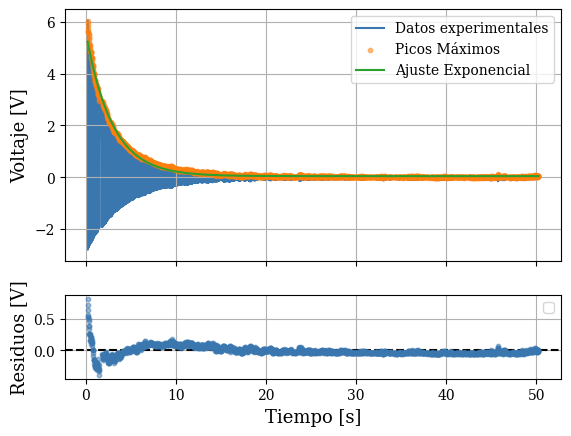

In [30]:
#calculo error daq
!pip install mpmath
import mpmath as mp
import scipy.stats as stats
from scipy.special import gammaincc  # Función gamma incompleta superior

def calculate_absolute_accuracy(reading):
    # Example values from the table for the 10V range
    range_value = 10  # Nominal range positive full scale
    residual_gain_error = 75*(10**-6)  # ppm of reading
    gain_tempoo = 7.3*(10**-6)  # ppm/°C
    reference_tempoo = 5*(10**-6)  # ppm/°C
    residual_offset_error = 20*(10**-6)  # ppm of range
    offset_tempoo = 34*(10**-6)  # ppm of range/°C
    inl_error = 76*(10**-6)  # ppm of range
    random_noise = 295*(10**-6)  # µVrms

    # Calculate GainError
    gain_error = residual_gain_error

    # Calculate OffsetError
    offset_error = residual_offset_error + inl_error

    # Calculate NoiseUncertainty
    noise_uncertainty = (random_noise * 3) / 100

    # Calculate Absolute Accuracy
    absolute_accuracy = reading * gain_error + range_value * offset_error + noise_uncertainty

    return absolute_accuracy

def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit3 = np.linspace(min(tiempo), max(tiempo), 1000)

mask_20s = t_max >= 10 # Seleccionar los picos correspondientes a t > 20 s
std_post20s = np.std(V_max[mask_20s]) # Calcular la desviación estándar solo para esos picos
errorVmax = np.sqrt(calculate_absolute_accuracy(V_max)**2 + std_post20s**2) #Para calcular el error tenemos en cuenta ambos errores

#----------Máximos-----------
C = min(V_max)
popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)
V_fit_max3 = exponencial(t_fit3, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)
print(dof)

def chi_cuadrado_reducido(observados, esperados, incertidumbres, num_parametros):
    N = len(observados)  # Número total de datos
    nu = N - num_parametros  # Grados de libertad
    chi2 = np.sum(((observados - esperados) / incertidumbres) ** 2)  # Suma de chi-cuadrado
    chi2_reducido = chi2 / nu  # Chi-cuadrado reducido
    return chi2_reducido
#calculo error daq
!pip install mpmath
import mpmath as mp
from scipy.special import loggamma
import numpy as np # import NumPy for the exp function

def calculate_absolute_accuracy(reading):
    # Example values from the table for the 10V range
    range_value = 10  # Nominal range positive full scale
    residual_gain_error = 75*(10**-6)  # ppm of reading
    gain_tempoo = 7.3*(10**-6)  # ppm/°C
    reference_tempoo = 5*(10**-6)  # ppm/°C
    residual_offset_error = 20*(10**-6)  # ppm of range
    offset_tempoo = 34*(10**-6)  # ppm of range/°C
    inl_error = 76*(10**-6)  # ppm of range
    random_noise = 295*(10**-6)  # µVrms

    # Calculate GainError
    gain_error = residual_gain_error

    # Calculate OffsetError
    offset_error = residual_offset_error + inl_error

    # Calculate NoiseUncertainty
    noise_uncertainty = (random_noise * 3) / 100

    # Calculate Absolute Accuracy
    absolute_accuracy = reading * gain_error + range_value * offset_error + noise_uncertainty

    return absolute_accuracy

def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit3 = np.linspace(min(tiempo), max(tiempo), 1000)

mask_20s = t_max >= 10 # Seleccionar los picos correspondientes a t > 20 s
std_post20s = np.std(V_max[mask_20s]) # Calcular la desviación estándar solo para esos picos
errorVmax = np.sqrt(calculate_absolute_accuracy(V_max)**2 + std_post20s**2) #Para calcular el error tenemos en cuenta ambos errores

#----------Máximos-----------
C = min(V_max)
popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)
V_fit_max3 = exponencial(t_fit3, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)
print(dof)

def chi_cuadrado_reducido(observados, esperados, incertidumbres, num_parametros):
    N = len(observados)
    nu = N - num_parametros
    chi2 = np.sum(((observados - esperados) / incertidumbres) ** 2)
    return chi2 / nu

chi2_red = chi_cuadrado_reducido(V_max, y_predicho, errorVmax, len(popt_max))

print(f"Chi-cuadrado reducido vol 2: {chi2_red:.4f}")

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, voltaje, color="#3a77af", label='Datos experimentales', zorder=1)
ax[0].scatter(t_max, V_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax[0].plot(t_fit3, V_fit_max3, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax[0].set_ylabel('Voltaje [V]', fontsize=13)
ax[0].grid()
ax[0].legend()

ax[1].axhline(0, color='black', linestyle='--')
ax[1].scatter(t_max, residuos, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax[1].set_xlabel('Tiempo [s]', fontsize=13)
ax[1].set_ylabel('Residuos [V]', fontsize=13)
ax[1].grid()
ax[1].legend()
plt.savefig('med5ajusteexponencial.svg', format='svg')
plt.show()

# Descargar el archivo a tu compu
from google.colab import files
#files.download('med5ajusteexponencial.svg')


In [31]:
#calculo error daq

def calculate_absolute_accuracy(reading):
    # Example values from the table for the 10V range
    range_value = 10  # Nominal range positive full scale
    residual_gain_error = 75*(10**-6)  # ppm of reading
    gain_tempoo = 7.3*(10**-6)  # ppm/°C
    temp_change_internal_cal = 5  # Example temperature change in °C
    reference_tempoo = 5*(10**-6)  # ppm/°C
    temp_change_external_cal = 5  # Example temperature change in °C
    residual_offset_error = 20*(10**-6)  # ppm of range
    offset_tempoo = 34*(10**-6)  # ppm of range/°C
    inl_error = 76*(10**-6)  # ppm of range
    random_noise = 295*(10**-6)  # µVrms

    # Calculate GainError
    gain_error = residual_gain_error + gain_tempoo * temp_change_internal_cal + reference_tempoo * temp_change_external_cal

    # Calculate OffsetError
    offset_error = residual_offset_error + offset_tempoo * temp_change_internal_cal + inl_error

    # Calculate NoiseUncertainty
    noise_uncertainty = (random_noise * 3) / 100

    # Calculate Absolute Accuracy
    absolute_accuracy = reading * gain_error + range_value * offset_error + noise_uncertainty

    return absolute_accuracy

# Seleccionar los picos correspondientes a t > 20 s
mask_20s = t_max >= 10

# Calcular la desviación estándar solo para esos picos
std_post20s = np.std(V_max[mask_20s])
errorVmax = np.sqrt(calculate_absolute_accuracy(V_max)**2 + std_post20s**2)


Ajuste para picos máximos:
A = 5.5949, α = 0.3438 +- 0.0012, C = 0.0409
Chi-cuadrado (χ²): 2558.9437
Chi-cuadrado reducido (χ²/ν): 1.0552
p-valor: 0.0288


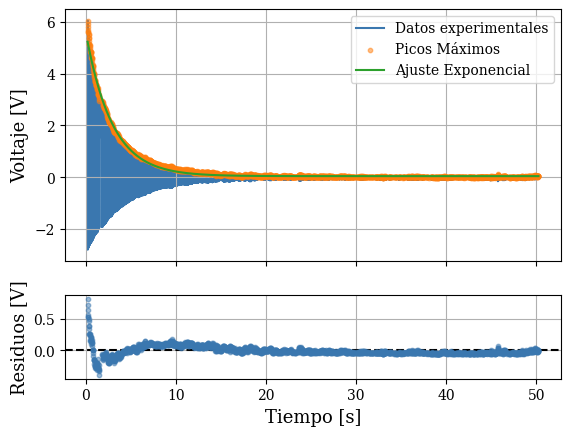

"\n#veamos los residuos en un intervalo temporal más corto\nplt.scatter(t_max, residuos, marker='o', s=10)\nplt.xlabel('Tiempo [s]', fontsize=13)\nplt.ylabel('Residuos [V]', fontsize=13)\nplt.xlim(20,30)\nplt.ylim(-0.1,0.1)\nplt.grid(True)\nplt.show()\n"

In [32]:
#pruebo lo que le voy a mandar a pablo
#defino función para el cálculo del error daq
def calculate_absolute_accuracy(reading):
    range_value = 10 # Nominal range positive full scale
    residual_gain_error = 75*(10**-6) # ppm of reading
    gain_tempoo = 7.3*(10**-6) # ppm/°C
    reference_tempoo = 5*(10**-6) # ppm/°C
    residual_offset_error = 20*(10**-6) # ppm of range
    offset_tempoo = 34*(10**-6) # ppm of range/°C
    inl_error = 76*(10**-6) # ppm of range
    random_noise = 295*(10**-6) # µVrms

    # Calculate GainError
    gain_error = residual_gain_error

    # Calculate OffsetError
    offset_error = residual_offset_error + inl_error

    # Calculate NoiseUncertainty
    noise_uncertainty = (random_noise * 3) / 100

    # Calculate Absolute Accuracy
    absolute_accuracy = reading * gain_error + range_value * offset_error + noise_uncertainty

    return absolute_accuracy
#--------------------------Cargo los datos----------------------------------------------
tiempo, voltaje = cargar_datos_csv("5MedFotodiodo-conirisA13MASTIEMPOL17-7cm0.csv")

#--------------------------Findpeaks----------------------------------------------------
#Encontrar picos máximos
voltaje = voltaje - np.mean(voltaje) #centramos en 0
peaks_max, _ = find_peaks(voltaje, prominence=0.05)

#Crear listas con los valores de los picos
t_max = tiempo[peaks_max]
V_max = voltaje[peaks_max]

"""
#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(tiempo, voltaje, label='Datos originales', color='gray', alpha=0.6)
plt.scatter(t_max, V_max, label='Picos Máximos', color='red', marker='o', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()
"""
#-----------------------Ajuste Exponencial----------------------------------------------
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit3 = np.linspace(min(tiempo), max(tiempo), 1000)

mask_20s = t_max >= 10 # Seleccionar los picos correspondientes a t > 20 s
std_post20s = np.std(V_max[mask_20s]) # Calcular la desviación estándar solo para esos picos
errorVmax = np.sqrt(calculate_absolute_accuracy(V_max)**2 + std_post20s**2) #Para calcular el error tenemos en cuenta ambos errores

C = min(V_max)
popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)
V_fit_max3 = exponencial(t_fit3, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max) # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, voltaje, color="#3a77af", label='Datos experimentales', zorder=1)
ax[0].scatter(t_max, V_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax[0].plot(t_fit3, V_fit_max3, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax[0].set_ylabel('Voltaje [V]', fontsize=13)
ax[0].grid()
ax[0].legend()

ax[1].axhline(0, color='black', linestyle='--')
ax[1].scatter(t_max, residuos, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax[1].set_xlabel('Tiempo [s]', fontsize=13)
ax[1].set_ylabel('Residuos [V]', fontsize=13)
ax[1].grid()
plt.savefig('med5ajusteexponencial.svg', format='svg')
plt.show()

# Descargar el archivo a tu compu
from google.colab import files
#files.download('med5ajusteexponencial.svg')

"""
#veamos los residuos en un intervalo temporal más corto
plt.scatter(t_max, residuos, marker='o', s=10)
plt.xlabel('Tiempo [s]', fontsize=13)
plt.ylabel('Residuos [V]', fontsize=13)
plt.xlim(20,30)
plt.ylim(-0.1,0.1)
plt.grid(True)
plt.show()
"""

Frecuencia estimada: 49.15 Hz


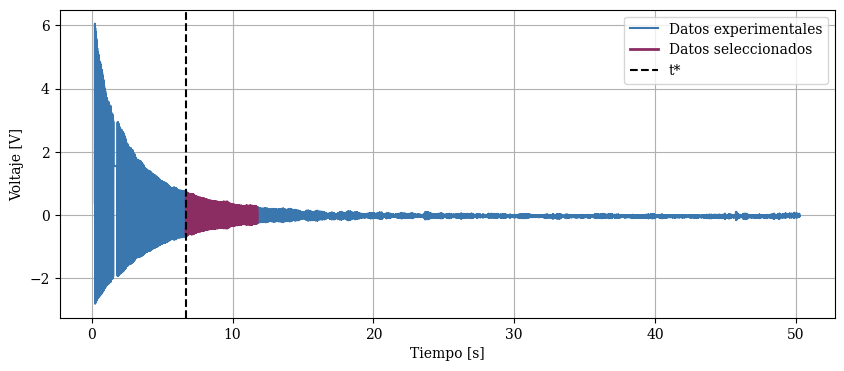

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

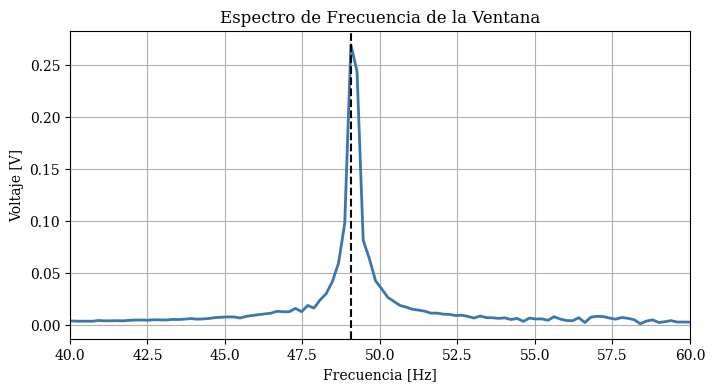

In [33]:
#Codigo para tomar N periodos
# Determinar t* donde la señal ha decaído al 10% de la inicial
t_star = -np.log(0.1) / alfamax

# Aplicar FFT a toda la señal para estimar la frecuencia dominante
frecuencias, fft_resultado = calcular_transformada_fourier(tiempo, voltaje)

# Encontrar la frecuencia dominante
indice_frecuencia_dominante = np.argmax(fft_resultado)
f_estimada = frecuencias[indice_frecuencia_dominante]  # Usamos la frecuencia dominante estimada

print(f"Frecuencia estimada: {f_estimada:.2f} Hz")
# Seleccionar N períodos desde t*
N = 250
T = 1 / f_estimada
idx_start = np.searchsorted(tiempo, t_star)
idx_end = idx_start + int(N * T * (len(tiempo) / max(tiempo)))  # Ajustamos por la resolución temporal

ventana = voltaje[idx_start:idx_end]
t_ventana = tiempo[idx_start:idx_end]

# Aplicar FFT sobre la ventana seleccionada
frecuencias_ventana, fft_resultado_ventana = calcular_transformada_fourier(t_ventana, ventana)
indice_frecuencia_dominante_ventana = np.argmax(fft_resultado_ventana)
f_estimada_ventana = frecuencias_ventana[indice_frecuencia_dominante_ventana]

# Graficar la señal original y la ventana seleccionada
plt.figure(figsize=(10, 4))
plt.plot(tiempo, voltaje, color="#3a77af", label='Datos experimentales')
plt.plot(t_ventana, ventana, label="Datos seleccionados", linewidth=2, color = "#8B2C62")
plt.axvline(t_star, color='black', linestyle='--', label="t*")
plt.legend()
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.grid()
# Guardar como SVG
plt.savefig('ventanafourier.svg', format='svg')

plt.show()



# Descargar el archivo a tu compu
from google.colab import files
files.download('ventanafourier.svg')

# Graficar la FFT de la ventana
plt.figure(figsize=(8, 4))
plt.plot(frecuencias_ventana, fft_resultado_ventana, color = "#3a77af", linewidth=2)
plt.xlabel("Frecuencia [Hz]")
plt.xlim(40,60)
plt.axvline(f_estimada_ventana, color='black', linestyle='--', label="t*")
plt.ylabel("Voltaje [V]")
plt.title("Espectro de Frecuencia de la Ventana")
plt.grid()
plt.show()


Ajuste para picos máximos:
A = 5.4707, α = 0.3333 +- 0.0011, C = 0.0363
Chi-cuadrado (χ²): 10398930.5640
Chi-cuadrado reducido (χ²/ν): 4288.2188
p-valor: 0.0000


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


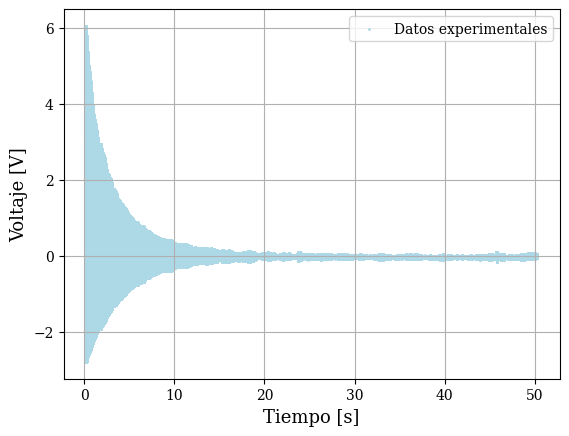

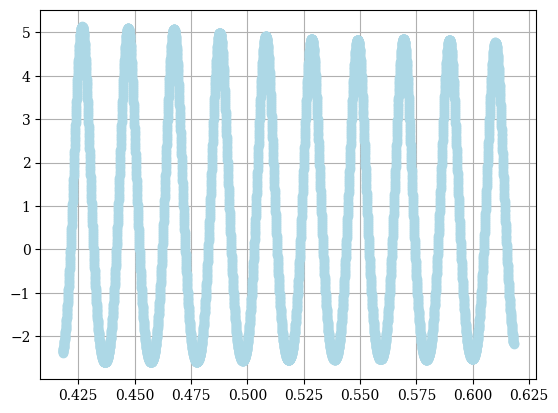

In [34]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit = np.linspace(min(tiempo), max(tiempo), 1000)

errorVmax = calculate_absolute_accuracy(V_max)
errorVmin = calculate_absolute_accuracy(V_min)

#----------Máximos-----------
popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)
V_fit_max = exponencial(t_fit, *popt_max)
erroralfa_max = np.sqrt(np.diag(pcov_max))[1]

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")


plt.scatter(tiempo, voltaje, color="lightblue",  label='Datos experimentales', s=1)
plt.xlabel('Tiempo [s]', fontsize=13)
plt.ylabel('Voltaje [V]', fontsize=13)
plt.grid(True)
plt.legend()
plt.show()

plt.plot(tiempo[5000:10000], voltaje[5000:10000],'o',label='Datos experimentales', color="lightblue")
plt.grid(True)
plt.show()

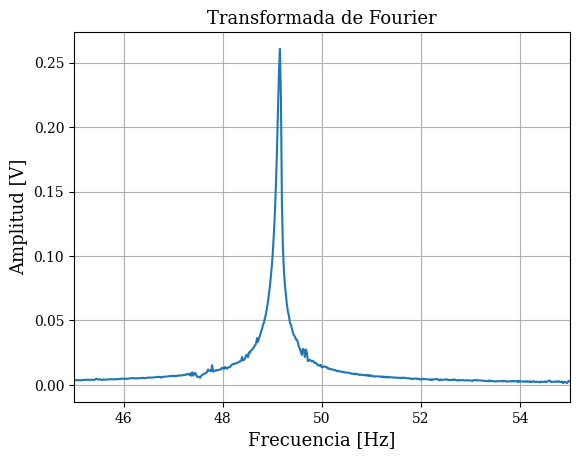

Frecuencia dominante: 49.15379102433411 Hz
Amplitud dominante: 0.2606159789954608 V


In [35]:
frecuencias, fft_resultado = calcular_transformada_fourier(tiempo, voltaje)

# Graficar el resultado
plt.figure()
plt.plot(frecuencias, fft_resultado)
plt.title('Transformada de Fourier', fontsize = 13)
plt.xlabel('Frecuencia [Hz]', fontsize = 13)
plt.xlim(45, 55)
plt.ylabel('Amplitud [V]' , fontsize = 13)
plt.grid()
plt.show()

#OBS: la amplitud puede parecer rara que este tan baja pero es porque le reste la media así quedaba en 0

# Encontrar la frecuencia dominante y su amplitud
indice_frecuencia_dominante = np.argmax(fft_resultado)
frecuencia_dominante = frecuencias[indice_frecuencia_dominante]
amplitud_dominante = fft_resultado[indice_frecuencia_dominante]

print(f"Frecuencia dominante: {frecuencia_dominante} Hz")
print(f"Amplitud dominante: {amplitud_dominante} V")

In [36]:
alfa = (alfamax + alfamin)*0.5
d = 0.5/100 # en metros
rho = 8960 * (np.pi * (d / 2) ** 2)  #del cobre
I = (np.pi * (d)**4)/64
L = 17.7/100 #en metros
k = 1.875/L
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print("El modulo de Young es de:", E/10**9)

El modulo de Young es de: 43.43601133444278


In [37]:
# NO asumimos que es completamente cobre
alfa = (alfamax + alfamin)*0.5
d = 0.5/100 # en metros
rho = (77/1000)*(1/(17.7/100))  #del cobre
I = (np.pi * (d)**4)/64
L = 17.7/100 #en metros
k = 1.875/L
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print("El modulo de Young es de:", E/10**9)

El modulo de Young es de: 107.40623592202513


In [38]:
L_err = 0.3/100
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 25000/len(frecuencias) # frec de meustreo/numero de puntos de la fft
alpha_err = 0.005 # sale de la matriz de covarianza
from uncertainties import ufloat

alfa_u = ufloat((alfamax+alfamin)/2, alpha_err)
d_u = ufloat(0.5/100, d_err)
rho_u = ufloat((77/1000)*(1/(17.7/100)), rho_err)
L_u = ufloat(17.7/100, L_err)
f_u = ufloat(frecuencia_dominante, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + ((alfamax+alfamin)/2)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

print(E_GPa_u)
print(f_err)

107+/-7
0.04020882857207191


##Medición 6 (medicion muy fea)

In [39]:
tiempo, voltaje = cargar_datos_csv("6MedFotodiodo-conirisA13MASTIEMPOL13cm0.csv")

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


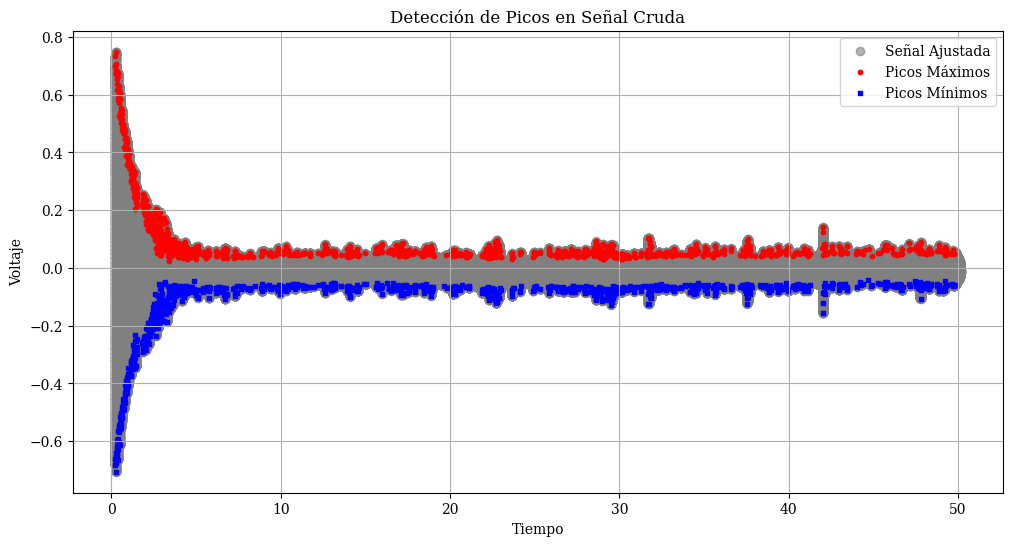

In [40]:
num_puntos_finales = 2000  # Ajusta según tu señal
offset = np.mean(voltaje[-num_puntos_finales:])
V_ajustada = voltaje - offset # Restar el offset para que al final la señal quede en 0

peaks_max, _ = find_peaks(V_ajustada, prominence=0.1, distance=40, width=50)
peaks_min, _ = find_peaks(-V_ajustada, prominence=0.1, distance=40, width=50)

#Crear listas con los valores de los picos
t_max = tiempo[peaks_max]
V_max = V_ajustada[peaks_max]

t_min = tiempo[peaks_min]
V_min = V_ajustada[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.scatter(tiempo, V_ajustada, label="Señal Ajustada", color='gray', alpha=0.6)
plt.scatter(t_max, V_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
#plt.xlim(15,20)
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

Ajuste para picos máximos:
A = 0.8181, α = 0.9117 +- 0.0094, C = 0.0544

Ajuste para picos mínimos:
A = -0.7265, α = 0.8090+- 0.0091, C = -0.0714


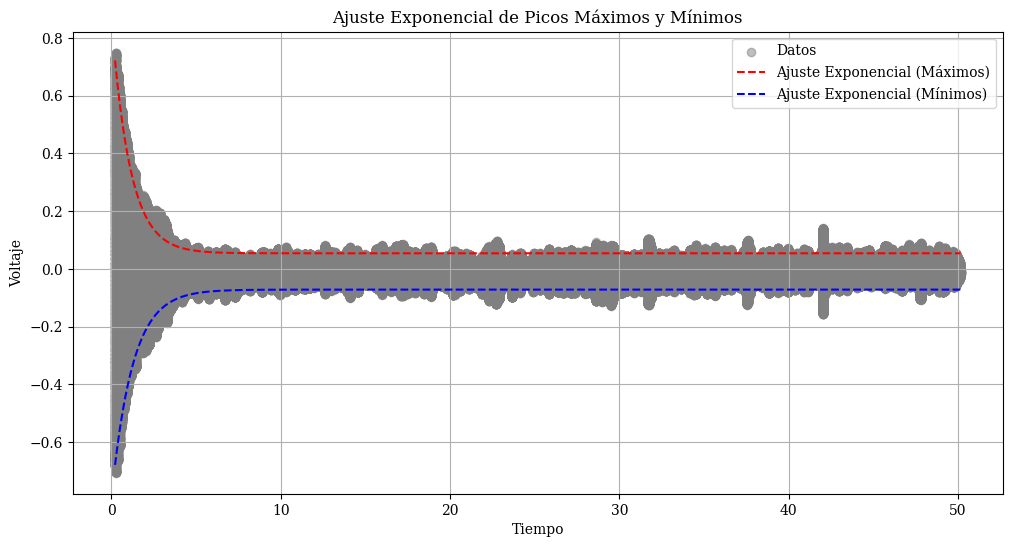

In [41]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

#Ajustar picos máximos
popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)])

#Ajustar picos mínimos
popt_min, pcov_min = curve_fit(exponencial, t_min, V_min, p0=[min(V_min), 0.1, max(V_min)])


plt.figure(figsize=(12, 6))
plt.scatter(tiempo, V_ajustada, label='Datos', color='gray', alpha=0.5)
#plt.scatter(t_max, V_max, label='Picos Máximos', color='red')
#plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue')

# Curvas ajustadas
t_fit = np.linspace(min(tiempo), max(tiempo), 1000)

V_fit_max = exponencial(t_fit, *popt_max)
erroralfa_max = np.sqrt(np.diag(pcov_max))[1]

V_fit_min = exponencial(t_fit, *popt_min)
erroralfa_min = np.sqrt(np.diag(pcov_min))[1]

alfamax = popt_max[1]
alfamin = popt_min[1]
#Resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {alfamax:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")

print("\nAjuste para picos mínimos:")
print(f"A = {popt_min[0]:.4f}, α = {alfamin:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}")


plt.plot(t_fit, V_fit_max, label='Ajuste Exponencial (Máximos)', color='red', linestyle='--')
plt.plot(t_fit, V_fit_min, label='Ajuste Exponencial (Mínimos)', color='blue', linestyle='--')

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Ajuste Exponencial de Picos Máximos y Mínimos')
plt.legend()
plt.grid(True)
plt.show()


Ajuste para picos máximos:
A = 0.8181, α = 0.9117 +- 0.0094, C = 0.0544
Chi-cuadrado (χ²): 2129.9199
Chi-cuadrado reducido (χ²/ν): 2.2141
p-valor: 0.0000


<ipython-input-42-e08ef3a74fd7>:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


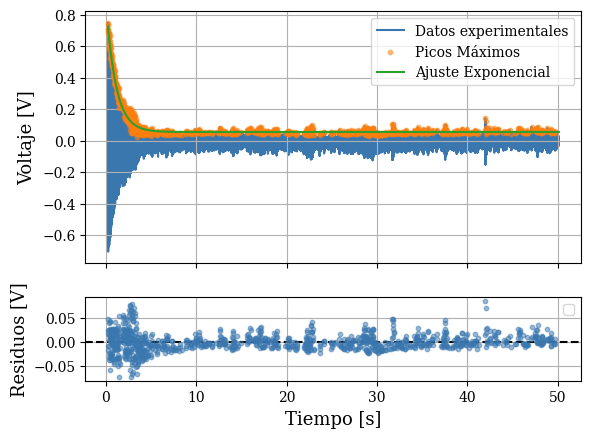

'\n#----------Mínimos-----------\npopt_min, pcov_min = curve_fit(exponencial, t_min, V_min, p0=[min(V_min), 0.1, max(V_min)],sigma=errorVmin)\n\nV_fit_min = exponencial(t_fit, *popt_min)\nerroralfa_min = np.sqrt(np.diag(pcov_min))[1]\n\n# Predicción y residuos\ny_predicho = exponencial(t_min, *popt_min)\nresiduos = V_min - y_predicho\n\n# Cálculo del Chi-cuadrado\nchi2_valor = np.sum((residuos / errorVmin) ** 2)\ndof = len(t_min) - len(popt_min)  # Grados de libertad\nchi2_reducido = chi2_valor / dof\np_valor = chi2.sf(chi2_valor, dof)\n\n#Resultados\nprint("\nAjuste para picos mínimos:")\nprint(f"A = {popt_min[0]:.4f}, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}")\nprint(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")\nprint(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")\nprint(f"p-valor: {p_valor:.4f}")\n\n# Gráficos\nfig, ax = plt.subplots(2, sharex=True, gridspec_kw={\'height_ratios\': [3, 1]})\n\nax[0].plot(tiempo, voltaje, \'o\', label=\'Datos experimentales

In [42]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit4 = np.linspace(min(tiempo), max(tiempo), 1000)

errorVmax = np.maximum(calculate_absolute_accuracy(V_max), np.std(V_max)/10)  # Evitar incertidumbres subestimadas

#----------Máximos-----------
#C = np.mean(V_max[int(len(V_max) * 0.8):])
C = min(V_max)

popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)
V_fit_max4 = exponencial(t_fit4, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, V_ajustada, color="#3a77af", label='Datos experimentales', zorder=1)
ax[0].scatter(t_max, V_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax[0].plot(t_fit4, V_fit_max4, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax[0].set_ylabel('Voltaje [V]', fontsize=13)
ax[0].grid()
ax[0].legend()

ax[1].axhline(0, color='black', linestyle='--')
ax[1].scatter(t_max, residuos, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax[1].set_xlabel('Tiempo [s]', fontsize=13)
ax[1].set_ylabel('Residuos [V]', fontsize=13)
ax[1].grid()
ax[1].legend()
plt.show()
"""
#----------Mínimos-----------
popt_min, pcov_min = curve_fit(exponencial, t_min, V_min, p0=[min(V_min), 0.1, max(V_min)],sigma=errorVmin)

V_fit_min = exponencial(t_fit, *popt_min)
erroralfa_min = np.sqrt(np.diag(pcov_min))[1]

# Predicción y residuos
y_predicho = exponencial(t_min, *popt_min)
residuos = V_min - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmin) ** 2)
dof = len(t_min) - len(popt_min)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

#Resultados
print("\nAjuste para picos mínimos:")
print(f"A = {popt_min[0]:.4f}, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, voltaje, 'o', label='Datos experimentales', color="grey")
# ax[0].plot(t_fit, V_fit_min, label=f'Ajuste Exponencial, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}', color="blue")
ax[0].plot(t_fit, V_fit_min, label=f'Ajuste Exponencial', color="blue")
ax[1].axhline(0, color = "black")
ax[1].errorbar(t_min, residuos, fmt=".", label="Residuos")
ax[1].set_xlabel('Tiempo [s]', fontsize=13)
ax[0].set_ylabel('Voltaje [V]', fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()
"""

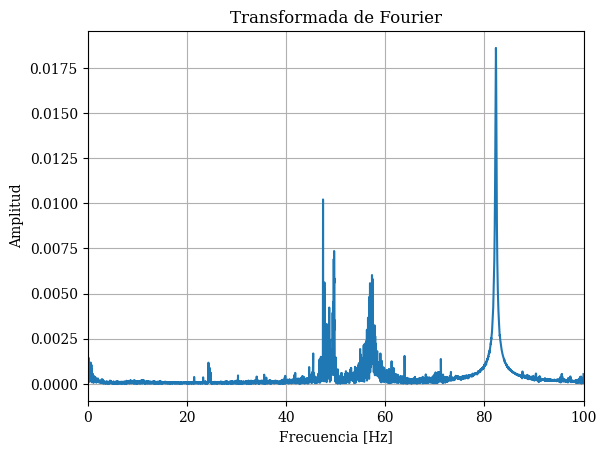

Frecuencia dominante: 82.33413512156983 Hz
Amplitud dominante: 0.018607128958279626 V


In [43]:
frecuencias, fft_resultado = calcular_transformada_fourier(tiempo, voltaje)

# Graficar el resultado
plt.figure()
plt.plot(frecuencias, fft_resultado)
plt.title('Transformada de Fourier')
plt.xlabel('Frecuencia [Hz]')
plt.xlim(0, 100)
plt.ylabel('Amplitud')
plt.grid()
plt.show()

#OBS: la amplitud puede parecer rara que este tan baja pero es porque le reste la media así quedaba en 0

# Encontrar la frecuencia dominante y su amplitud
indice_frecuencia_dominante = np.argmax(fft_resultado)
frecuencia_dominante = frecuencias[indice_frecuencia_dominante]
amplitud_dominante = fft_resultado[indice_frecuencia_dominante]

print(f"Frecuencia dominante: {frecuencia_dominante} Hz")
print(f"Amplitud dominante: {amplitud_dominante} V")

In [44]:
alfa = (alfamax + alfamin)*0.5
d = 0.5/100 # en metros
rho = 8960 * (np.pi * (d / 2) ** 2)  #del cobre
I = (np.pi * (d)**4)/64
L = 13/100 #en metros
k = 1.875/L
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print("El modulo de Young es de:", E/10**9)
print("rho", rho)
print("I", I)
print("k", k)

El modulo de Young es de: 35.46313278912288
rho 0.1759291886010284
I 3.067961575771282e-11
k 14.423076923076923


In [45]:
# NO asumimos que es completamente cobre
alfa = (alfamax + alfamin)*0.5
d = 0.5/100 # en metros
rho = (77/1000)*(1/(13/100))  #del cobre
I = (np.pi * (d)**4)/64
L = 13/100 #en metros
k = 1.875/L
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print("El modulo de Young es de:", E/10**9)

El modulo de Young es de: 119.39511863470184


In [46]:
L_err = 0.001
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 25000/len(frecuencias) # frec de meustreo/numero de puntos de la fft
alpha_err = 0.005 # sale de la matriz de covarianza
from uncertainties import ufloat

alfa_u = ufloat((alfamax+alfamin)/2, alpha_err)
d_u = ufloat(0.5/100, d_err)
rho_u = ufloat((77/1000)*(1/(13/100)), rho_err)
L_u = ufloat(13/100, L_err)
f_u = ufloat(frecuencia_dominante, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + ((alfamax+alfamin)/2)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u

119.39511863470184+/-3.7982173277565696

##Medición 7

In [47]:
tiempo, voltaje = cargar_datos_csv("7MedFotodiodo-conirisA13-50seg-L29-2cm0.csv")

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


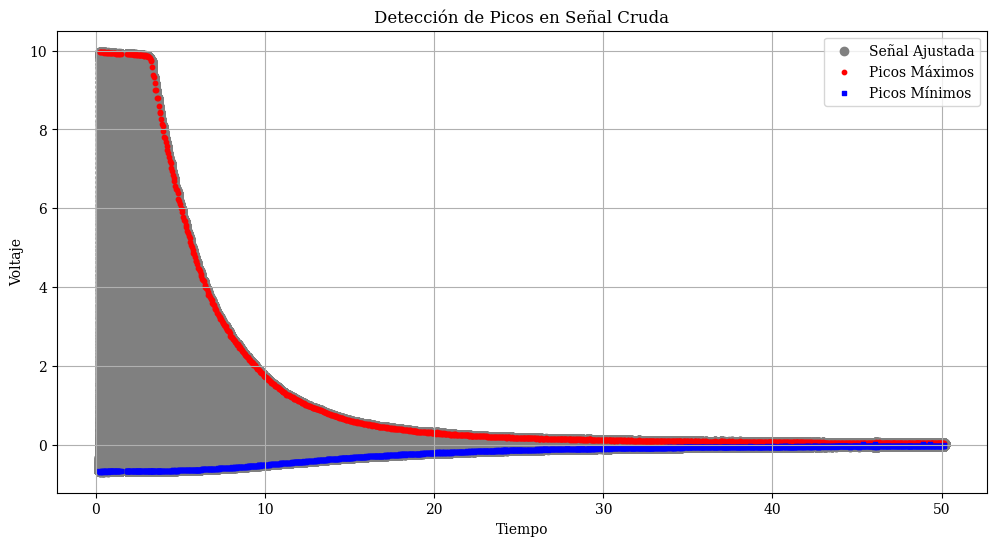

In [48]:
from scipy.signal import savgol_filter


num_puntos_finales = 2000  # Ajusta según tu señal
offset = np.mean(voltaje[-num_puntos_finales:])
V_ajustada = voltaje - offset # Restar el offset para que al final la señal quede en 0

peaks_max, _ = find_peaks(V_ajustada, height=0.001, distance=10, prominence=0.05)
peaks_min, _ = find_peaks(-V_ajustada, prominence=0.001, distance=5, width=30)

#Crear listas con los valores de los picos
t_max = tiempo[peaks_max]
V_max = V_ajustada[peaks_max]

t_min = tiempo[peaks_min]
V_min = V_ajustada[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.scatter(tiempo, V_ajustada, label="Señal Ajustada", color='gray')
plt.scatter(t_max, V_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

Ajuste para picos máximos:
A = 13.7648, α = 0.1897 +- 0.0017, C = 0.0129
Chi-cuadrado (χ²): 114552536.7820
Chi-cuadrado reducido (χ²/ν): 98582.2175
p-valor: 0.0000


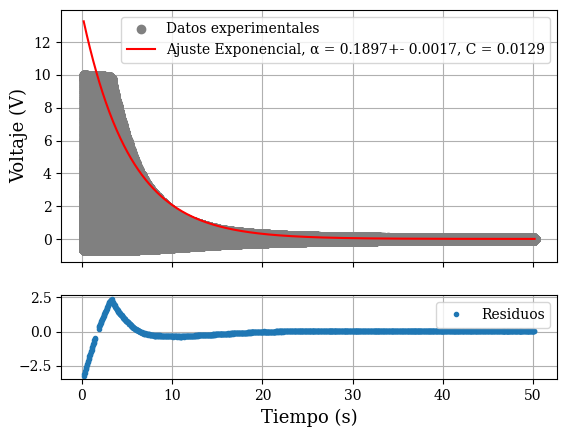


Ajuste para picos mínimos:
A = -0.8735, α = 0.0530+- 0.0008, C = 0.0609
Chi-cuadrado (χ²): 2012381.4387
Chi-cuadrado reducido (χ²/ν): 1444.6385
p-valor: 0.0000


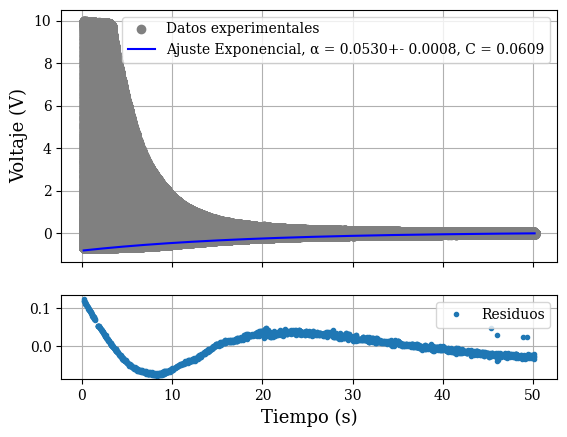

In [49]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit = np.linspace(min(tiempo), max(tiempo), 1000)

errorVmax = calculate_absolute_accuracy(V_max)
errorVmin = calculate_absolute_accuracy(V_min)

#----------Máximos-----------
popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)
V_fit_max = exponencial(t_fit, *popt_max)
erroralfa_max = np.sqrt(np.diag(pcov_max))[1]

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, V_ajustada,'o', label='Datos experimentales', color="grey")
ax[0].plot(t_fit, V_fit_max, 'r-', label=f'Ajuste Exponencial, α = {popt_max[1]:.4f}+- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}')
ax[1].errorbar(t_max, residuos, fmt=".", label="Residuos")
ax[1].set_xlabel('Tiempo (s)', fontsize=13)
ax[0].set_ylabel('Voltaje (V)', fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()

#----------Mínimos-----------
popt_min, pcov_min = curve_fit(exponencial, t_min, V_min, p0=[min(V_min), 0.1, max(V_min)],sigma=errorVmin)

V_fit_min = exponencial(t_fit, *popt_min)
erroralfa_min = np.sqrt(np.diag(pcov_min))[1]

# Predicción y residuos
y_predicho = exponencial(t_min, *popt_min)
residuos = V_min - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmin) ** 2)
dof = len(t_min) - len(popt_min)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

#Resultados
print("\nAjuste para picos mínimos:")
print(f"A = {popt_min[0]:.4f}, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, V_ajustada, 'o', label='Datos experimentales', color="grey")
ax[0].plot(t_fit, V_fit_min, label=f'Ajuste Exponencial, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}', color="blue")
ax[1].errorbar(t_min, residuos, fmt=".", label="Residuos")
ax[1].set_xlabel('Tiempo (s)', fontsize=13)
ax[0].set_ylabel('Voltaje (V)', fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()

Ajuste para picos máximos:
A = 13.3811, α = 0.1755 +- 0.0020, C = -0.0392
Chi-cuadrado (χ²): 4111.6474
Chi-cuadrado reducido (χ²/ν): 3.5384
p-valor: 0.0000


<ipython-input-50-673dd6498a99>:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


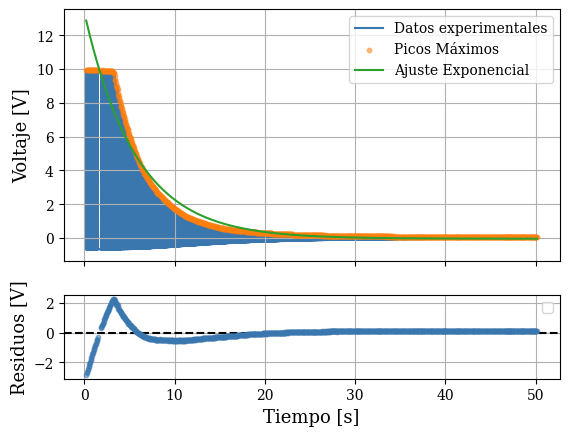

'\n#----------Mínimos-----------\npopt_min, pcov_min = curve_fit(exponencial, t_min, V_min, p0=[min(V_min), 0.1, max(V_min)],sigma=errorVmin)\n\nV_fit_min = exponencial(t_fit, *popt_min)\nerroralfa_min = np.sqrt(np.diag(pcov_min))[1]\n\n# Predicción y residuos\ny_predicho = exponencial(t_min, *popt_min)\nresiduos = V_min - y_predicho\n\n# Cálculo del Chi-cuadrado\nchi2_valor = np.sum((residuos / errorVmin) ** 2)\ndof = len(t_min) - len(popt_min)  # Grados de libertad\nchi2_reducido = chi2_valor / dof\np_valor = chi2.sf(chi2_valor, dof)\n\n#Resultados\nprint("\nAjuste para picos mínimos:")\nprint(f"A = {popt_min[0]:.4f}, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}")\nprint(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")\nprint(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")\nprint(f"p-valor: {p_valor:.4f}")\n\n# Gráficos\nfig, ax = plt.subplots(2, sharex=True, gridspec_kw={\'height_ratios\': [3, 1]})\n\nax[0].plot(tiempo, voltaje, \'o\', label=\'Datos experimentales

In [50]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit5 = np.linspace(min(tiempo), max(tiempo), 1000)

errorVmax = np.maximum(calculate_absolute_accuracy(V_max), np.std(V_max)/10)  # Evitar incertidumbres subestimadas

#----------Máximos-----------
#C = np.mean(V_max[int(len(V_max) * 0.8):])
C = min(V_max)

popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)
V_fit_max5 = exponencial(t_fit5, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, V_ajustada, color="#3a77af", label='Datos experimentales', zorder=1)
ax[0].scatter(t_max, V_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax[0].plot(t_fit5, V_fit_max5, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax[0].set_ylabel('Voltaje [V]', fontsize=13)
ax[0].grid()
ax[0].legend()

ax[1].axhline(0, color='black', linestyle='--')
ax[1].scatter(t_max, residuos, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax[1].set_xlabel('Tiempo [s]', fontsize=13)
ax[1].set_ylabel('Residuos [V]', fontsize=13)
ax[1].grid()
ax[1].legend()
plt.show()
"""
#----------Mínimos-----------
popt_min, pcov_min = curve_fit(exponencial, t_min, V_min, p0=[min(V_min), 0.1, max(V_min)],sigma=errorVmin)

V_fit_min = exponencial(t_fit, *popt_min)
erroralfa_min = np.sqrt(np.diag(pcov_min))[1]

# Predicción y residuos
y_predicho = exponencial(t_min, *popt_min)
residuos = V_min - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmin) ** 2)
dof = len(t_min) - len(popt_min)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

#Resultados
print("\nAjuste para picos mínimos:")
print(f"A = {popt_min[0]:.4f}, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, voltaje, 'o', label='Datos experimentales', color="grey")
# ax[0].plot(t_fit, V_fit_min, label=f'Ajuste Exponencial, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}', color="blue")
ax[0].plot(t_fit, V_fit_min, label=f'Ajuste Exponencial', color="blue")
ax[1].axhline(0, color = "black")
ax[1].errorbar(t_min, residuos, fmt=".", label="Residuos")
ax[1].set_xlabel('Tiempo [s]', fontsize=13)
ax[0].set_ylabel('Voltaje [V]', fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()
"""

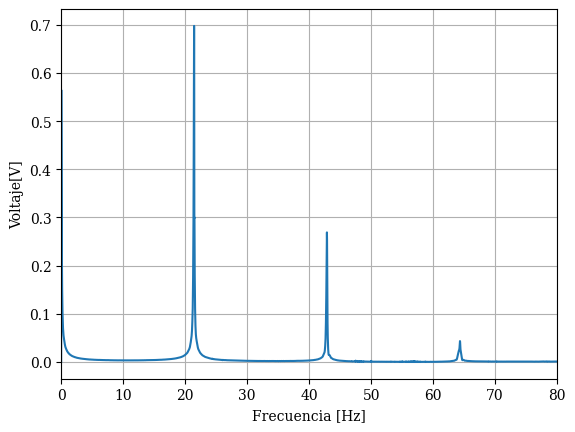

Frecuencia dominante: 21.442793769343695 Hz
Amplitud dominante: 0.6978019350749382 V


In [59]:
frecuencias, fft_resultado = calcular_transformada_fourier(tiempo, V_ajustada)

# Graficar el resultado
plt.figure()
plt.plot(frecuencias, fft_resultado)
plt.xlabel('Frecuencia [Hz]')
plt.xlim(0, 80)
plt.ylabel('Voltaje[V]')
plt.grid()
plt.show()

#OBS: la amplitud puede parecer rara que este tan baja pero es porque le reste la media así quedaba en 0

# Encontrar la frecuencia dominante y su amplitud
indice_frecuencia_dominante = np.argmax(fft_resultado)
frecuencia_dominante = frecuencias[indice_frecuencia_dominante]
amplitud_dominante = fft_resultado[indice_frecuencia_dominante]

print(f"Frecuencia dominante: {frecuencia_dominante} Hz")
print(f"Amplitud dominante: {amplitud_dominante} V")

In [52]:
alfa = (alfamax + alfamin)*0.5
d = 0.5/100 # en metros
rho = 8960 * (np.pi * (d / 2) ** 2)  #del cobre
I = (np.pi * (d)**4)/64
L = 29.2/100 #en metros
k = 1.875/L
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print("El modulo de Young es de:", E/10**9)
print("rho", rho)
print("I", I)
print("k", k)

El modulo de Young es de: 61.22694262773523
rho 0.1759291886010284
I 3.067961575771282e-11
k 6.421232876712329


In [53]:
# NO asumimos que es completamente cobre
alfa = (alfamax + alfamin)*0.5
d = 0.5/100 # en metros
rho = (77/1000)*(1/(29.2/100))  #del cobre
I = (np.pi * (d)**4)/64
L = 29.2/100 #en metros
k = 1.875/L
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print("El modulo de Young es de:", E/10**9)

El modulo de Young es de: 91.77249680281452


In [54]:
L_err = 0.001
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 25000/len(frecuencias) # frec de meustreo/numero de puntos de la fft
alpha_err = 0.005 # sale de la matriz de covarianza
from uncertainties import ufloat

alfa_u = ufloat((alfamax+alfamin)/2, alpha_err)
d_u = ufloat(0.5/100, d_err)
rho_u = ufloat((77/1000)*(1/(29.2/100)), rho_err)
L_u = ufloat(29.2/100, L_err)
f_u = ufloat(frecuencia_dominante, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + ((alfamax+alfamin)/2)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u

91.77249680281452+/-1.5004889495033362

In [55]:
L = np.array([ 25.6, 23.5, 17.7, 13.0, 29.2])/100 #longitudes de la varilla de cobre
#x_cobre = np.array([23.5, 17.7, 13.0]) /100 #longitudes de la varilla de cobre en metros
E = np.array([96.74211353981278, 101.61360123436677, 107.40628343180688,  119.3951186347018, 91.77133799875648 ]) #E que calculamos / longitud de la medición
#y_cobre = np.array([ 101.61360123436677, 107.40628343180688,  119.3951186347018 ]) #E que calculamos / longitud de la medición
alfa = ([])
rho = ([])
d =([])


## Todas las exponenciales juntas


# Nueva sección

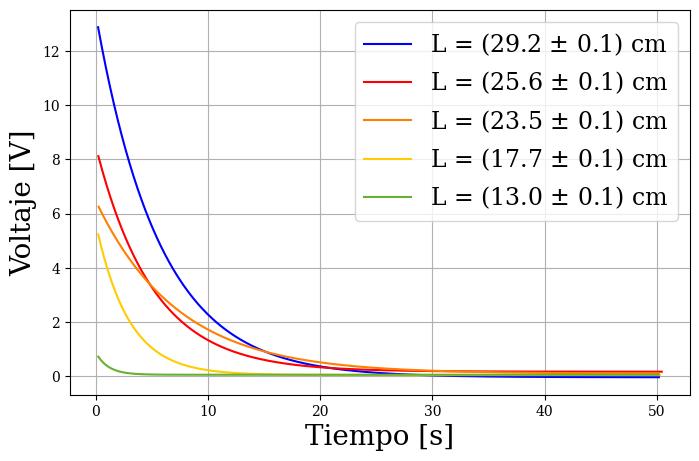

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
plt.figure(figsize=(8, 5))

plt.plot(t_fit5, V_fit_max5, color = '#0000FF', label='L = (29.2 $\pm$ 0.1) cm', zorder=3)  # Azul
plt.plot(t_fit_max1, V_fit_max1, color = '#FF0000', label='L = (25.6 $\pm$ 0.1) cm', zorder=3)  # Rojo
plt.plot(t_fit_max2, V_fit_max2, color = '#FF7F00', label='L = (23.5 $\pm$ 0.1) cm', zorder=3)  # Naranja
plt.plot(t_fit3, V_fit_max3, color = '#FFCC00', label='L = (17.7 $\pm$ 0.1) cm', zorder=3)  # Amarillo
plt.plot(t_fit4, V_fit_max4, color = '#66B032', label='L = (13.0 $\pm$ 0.1) cm', zorder=3)  # Verde
plt.xlabel('Tiempo [s]', fontsize=20)
plt.ylabel('Voltaje [V]', fontsize=20)
plt.grid()
plt.legend(fontsize=17)
# Guardar como SVG
plt.savefig('exponencialestot.svg', format='svg')

plt.show()



# Descargar el archivo a tu compu
from google.colab import files
files.download('exponencialestot.svg')

# Medicion 2

In [57]:
df = pd.read_csv("med2-24-2-acero-inoxidable-30cm0.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'med2-24-2-acero-inoxidable-30cm0.csv'

In [ ]:
df.columns = ["t2","V2"]
plt.plot(df["t2"], df["V2"])

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(df["t2"], df["V2"], '.', markersize=2, color="orange")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Datos originales")
plt.show()

fraction = 0.5
n_points = int(len(df) * fraction)
df_tail = df.iloc[-n_points:]

p = np.polyfit(df_tail["t2"], df_tail["V2"], 1)

recta_ajustada = np.polyval(p, df["t2"])

df["V2_corregido"] = df["V2"] - recta_ajustada

plt.figure(figsize=(6, 4))
plt.plot(df["t2"], df["V2_corregido"], '.', markersize=2, color="blue")
plt.axhline(np.mean(df["V2_corregido"]), color='red', linestyle='--', label="Media")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje corregido [V]")
plt.title("Datos después de restar la tendencia lineal")
plt.show()

print(f"Ecuación de la recta ajustada: V(t) = {p[0]:.6f} * t + {p[1]:.6f}")
print(f"mean: {np.mean(df['V2_corregido'])}")

In [ ]:
t2 = df["t2"].to_numpy()
v2 = df["V2_corregido"].to_numpy()

In [ ]:
peaks_max, _ = find_peaks(v2, prominence=0.002)
peaks_min, _ = find_peaks(-v2, prominence=0.002)# Para mínimos, buscamos picos en la señal invertida

#Crear listas con los valores de los picos
t2_max = t2[peaks_max]
V2_max = v2[peaks_max]

t2_min = t2[peaks_min]
V2_min = v2[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(t2, v2, label='Datos originales', color='gray', alpha=0.6)
plt.scatter(t2_max, V2_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t2_min, V2_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
errorVmax = calculate_absolute_accuracy(V2_max)# Evitar incertidumbres subestimadas
errorVmin = calculate_absolute_accuracy(V2_min)

In [ ]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit_max2 = np.linspace(min(t2_max), max(t2_max), 1000)

popt_max, pcov_max = curve_fit(
    exponencial, t2_max, V2_max,
    p0=[max(V2_max), 0.1, min(V2_max)], sigma=errorVmax)

V_fit_max2 = exponencial(t_fit_max2, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

residuos_max = V2_max - exponencial(t2_max, *popt_max)

fig1, ax1 = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1[0].plot(t2, v2, color="#3a77af", label='Datos experimentales', zorder=1)
ax1[0].scatter(t2_max, V2_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax1[0].plot(t_fit_max2, V_fit_max2, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax1[0].set_ylabel('Voltaje [V]', fontsize=13)
ax1[0].set_xlim(0,50)
ax1[0].grid()
ax1[0].legend()

ax1[1].axhline(0, color='black', linestyle='--')
ax1[1].scatter(t2_max, residuos_max, color='#3a77af',alpha=0.5, s=10, zorder=3)
ax1[1].set_xlabel('Tiempo$ [s]', fontsize=13)
ax1[1].set_ylabel('Residuos [V]', fontsize=13)
ax1[1].grid()
ax1[1].legend()

print("alfa", popt_max[1])

# Predicción y residuos
y_predicho = exponencial(t2_max, *popt_max)
residuos = V2_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t2_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

In [ ]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit_max2 = np.linspace(min(t2_max), max(t2_max), 1000)

popt_max, pcov_max = curve_fit(
    exponencial, t2_max, V2_max,
    p0=[max(V2_max), 0.1, min(V2_max)], sigma=errorVmax)

V_fit_max2 = exponencial(t_fit_max2, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax = popt_max[1]

residuos_max = V2_max - exponencial(t2_max, *popt_max)

fig1, ax1 = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1[0].plot(t2, v2, color="#3a77af", label='Datos experimentales', zorder=1)
ax1[0].scatter(t2_max, V2_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax1[0].plot(t_fit_max2, V_fit_max2, color='#2ca02c', label='Ajuste Exponencial', zorder=3)
ax1[0].set_ylabel('Voltaje [V]', fontsize=13)
ax1[0].set_xlim(0, 50)
ax1[0].grid()
ax1[0].legend()

ax1[1].axhline(0, color='black', linestyle='--')
ax1[1].scatter(t2_max, residuos_max, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax1[1].set_xlabel('Tiempo [s]', fontsize=13)
ax1[1].set_ylabel('Residuos [V]', fontsize=13)
ax1[1].grid()
ax1[1].legend()

# Aplicar notación científica en el eje Y
ax1[0].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax1[0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

ax1[1].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax1[1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.show()

# Predicción y residuos
y_predicho = exponencial(t2_max, *popt_max)
residuos = V2_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t2_max) - len(popt_max)
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} ± {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")


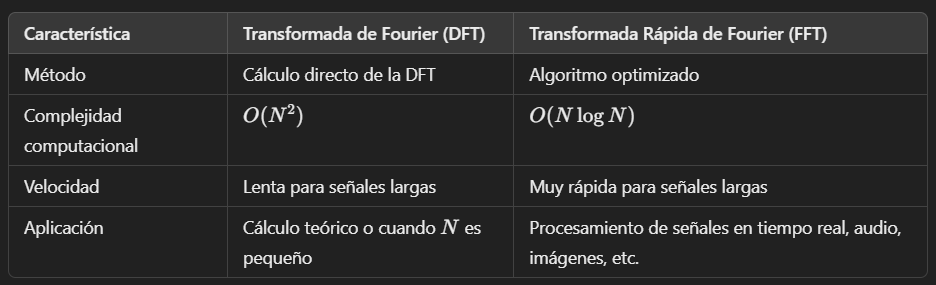

In [ ]:
alfamax = popt_max[1]
t_star = -np.log(0.1) / alfamax

frecuencias, fft_resultado = calcular_transformada_fourier(t2, v2)

picos, propiedades = find_peaks(fft_resultado, height=np.max(fft_resultado) * 0.5, prominence=np.max(fft_resultado) * 0.1)
indice_frecuencia_dominante = picos[np.argmax(propiedades['peak_heights'])]
f_estimada = frecuencias[indice_frecuencia_dominante]

altura_max = np.max(fft_resultado)
mitad_altura = altura_max / 2

indices_mitad = np.where(fft_resultado >= mitad_altura)[0]
ancho_mitad = frecuencias[indices_mitad[-1]] - frecuencias[indices_mitad[0]]

error_f = ancho_mitad

N = 250
T = 1 / f_estimada
idx_start = np.searchsorted(t2, t_star)
idx_end = idx_start + int(N * T * (len(t2) / max(t2)))

ventana = v2[idx_start:idx_end]
t_ventana = t2[idx_start:idx_end]

frecuencias_ventana, fft_resultado_ventana = calcular_transformada_fourier(t_ventana, ventana)
indice_frecuencia_dominante_ventana = np.argmax(fft_resultado_ventana)
f_estimada_ventana = frecuencias_ventana[indice_frecuencia_dominante_ventana]

plt.figure(figsize=(10, 4))
plt.plot(t2, v2, label="Señal original", color='#3a77af')
plt.plot(t_ventana, ventana, label="Ventana", linewidth=2, color="#8B2C62")
plt.axvline(t_star, color='black', linestyle='--', label="t*")
plt.legend()
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Señal original y ventana seleccionada")
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(frecuencias_ventana, fft_resultado_ventana, label="FFT de la Ventana")
plt.scatter(f_estimada_ventana, np.max(fft_resultado_ventana), color='red', zorder=3, label=f"Pico: {f_estimada_ventana:.2f} ± {error_f:.2f} Hz")
plt.axvline(f_estimada_ventana, color='red', linestyle='--')
plt.xlabel("Frecuencia [Hz]")
plt.xlim(20, 50)
plt.ylabel("Voltaje [V]")
plt.title("Espectro de Frecuencia de la Ventana")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib.ticker as ticker

plt.figure(figsize=(8, 4))
plt.plot(frecuencias_ventana, fft_resultado_ventana, label="FFT de la Ventana")
plt.scatter(f_estimada_ventana, np.max(fft_resultado_ventana), color='red', zorder=3, label=f"Pico: {f_estimada_ventana:.2f} ± {error_f:.2f} Hz")
plt.axvline(f_estimada_ventana, color='red', linestyle='--')

plt.xlabel("Frecuencia [Hz]")
plt.xlim(20, 50)
plt.ylabel("Voltaje [V]")
plt.title("Espectro de Frecuencia de la Ventana")
plt.legend()
plt.grid()

# Aplicar notación científica al eje Y con 1 cifra significativa
ax = plt.gca()
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)  # Activa la notación científica
formatter.set_powerlimits((0, 0))  # Fuerza la notación científica en todo el rango
ax.yaxis.set_major_formatter(formatter)

plt.show()



In [ ]:
L = 30/100
alpha = 0.1143 # 0.1143 +- 0.0018
d = 0.6/100
rho = (123/1000)*(1/(L))  #del cobr  # kg/m

f = 35.08

L_err = 0.001
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 0.08 #
alpha_err = 0.0018 # sale de la matriz de covarianza

from uncertainties import ufloat

alfa_u = ufloat(alpha, alpha_err)
d_u = ufloat(d , d_err)
rho_u = ufloat(rho, rho_err)
L_u = ufloat(L, L_err)
f_u = ufloat(f, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + (alfa_u)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u
print(f"Módulo de Young: {E_GPa_u:.2f} GPa")

# Medicion 3


In [ ]:
df = pd.read_csv("med3-24-2-acero-inoxidable-30cm0.csv")

In [ ]:
df.columns = ["t3","V3"]

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(df["t3"], df["V3"], '.', markersize=2, color="orange")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Datos originales")
plt.show()

fraction = 0.5
n_points = int(len(df) * fraction)
df_tail = df.iloc[-n_points:]

p = np.polyfit(df_tail["t3"], df_tail["V3"], 1)

recta_ajustada = np.polyval(p, df["t3"])

df["V3_corregido"] = df["V3"] - recta_ajustada

plt.figure(figsize=(6, 4))
plt.plot(df["t3"], df["V3_corregido"], '.', markersize=2, color="blue")
plt.axhline(np.mean(df["V3_corregido"]), color='red', linestyle='--', label="Media")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje corregido [V]")
plt.title("Datos después de restar la tendencia lineal")
plt.show()

print(f"Ecuación de la recta ajustada: V(t) = {p[0]:.6f} * t + {p[1]:.6f}")
print(f"mean: {np.mean(df['V3_corregido'])}")

In [ ]:
t3 = df["t3"].to_numpy()
v3 = df["V3_corregido"].to_numpy()

In [ ]:
peaks_max, _ = find_peaks(v3, prominence=0.0018)
peaks_min, _ = find_peaks(-v3, prominence=0.0018)# Para mínimos, buscamos picos en la señal invertida

#Crear listas con los valores de los picos
t3_max = t3[peaks_max]
V3_max = v3[peaks_max]

t3_min = t3[peaks_min]
V3_min = v3[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(t3, v3, label='Datos originales', color='gray', alpha=0.6)
plt.scatter(t3_max, V3_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t3_min, V3_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
errorVmax = np.maximum(calculate_absolute_accuracy(V3_max), np.std(V3_max)/10)  # Evitar incertidumbres subestimadas
errorVmin = np.maximum(calculate_absolute_accuracy(V3_min), np.std(V3_min)/10)

In [ ]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit_max3 = np.linspace(min(t3_max), max(t3_max), 1000)

popt_max, pcov_max = curve_fit(
    exponencial, t3_max, V3_max,
    p0=[max(V3_max), 0.1, min(V3_max)], sigma=errorVmax)

V_fit_max3 = exponencial(t_fit_max3, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

residuos_max = V3_max - exponencial(t3_max, *popt_max)

fig1, ax1 = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1[0].plot(t3, v3, color="#3a77af", label='Datos experimentales', zorder=1)
ax1[0].scatter(t3_max, V3_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax1[0].plot(t_fit_max3, V_fit_max3, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax1[0].set_ylabel('Voltaje [V]', fontsize=13)
ax1[0].set_xlim(0,50)
ax1[0].grid()
ax1[0].legend()

ax1[1].axhline(0, color='black', linestyle='--')
ax1[1].scatter(t3_max, residuos_max, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax1[1].set_xlabel('Tiempo [s]', fontsize=13)
ax1[1].set_ylabel('Residuos [V]', fontsize=13)
ax1[1].grid()
ax1[1].legend()

print("alfa", popt_max[1])

# Predicción y residuos
y_predicho = exponencial(t3_max, *popt_max)
residuos = V3_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t3_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

In [ ]:
alfamax = popt_max[1]
t_star = -np.log(0.1) / alfamax

frecuencias, fft_resultado = calcular_transformada_fourier(t3, v3)

picos, propiedades = find_peaks(fft_resultado, height=np.max(fft_resultado) * 0.5, prominence=np.max(fft_resultado) * 0.1)
indice_frecuencia_dominante = picos[np.argmax(propiedades['peak_heights'])]
f_estimada = frecuencias[indice_frecuencia_dominante]

altura_max = np.max(fft_resultado)
mitad_altura = altura_max / 2

indices_mitad = np.where(fft_resultado >= mitad_altura)[0]
ancho_mitad = frecuencias[indices_mitad[-1]] - frecuencias[indices_mitad[0]]

error_f = ancho_mitad

N = 250
T = 1 / f_estimada
idx_start = np.searchsorted(t3, t_star)
idx_end = idx_start + int(N * T * (len(t3) / max(t3)))

ventana = v3[idx_start:idx_end]
t_ventana = t3[idx_start:idx_end]

frecuencias_ventana, fft_resultado_ventana = calcular_transformada_fourier(t_ventana, ventana)
indice_frecuencia_dominante_ventana = np.argmax(fft_resultado_ventana)
f_estimada_ventana = frecuencias_ventana[indice_frecuencia_dominante_ventana]

plt.figure(figsize=(10, 4))
plt.plot(t3, v3, label="Señal original", color='#3a77af')
plt.plot(t_ventana, ventana, label="Ventana", linewidth=2, color="#8B2C62")
plt.axvline(t_star, color='black', linestyle='--', label="t*")
plt.legend()
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Señal original y ventana seleccionada")
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(frecuencias_ventana, fft_resultado_ventana, label="FFT de la Ventana")
plt.scatter(f_estimada_ventana, np.max(fft_resultado_ventana), color='red', zorder=3, label=f"Pico: {f_estimada_ventana:.2f} ± {error_f:.2f} Hz")
plt.axvline(f_estimada_ventana, color='red', linestyle='--')
plt.xlabel("Frecuencia [Hz]")
plt.xlim(20, 50)
plt.ylabel("Voltaje [V]")
plt.title("Espectro de Frecuencia de la Ventana")
plt.legend()
plt.grid()
plt.show()

In [ ]:
L = 30/100
alpha = 0.1143 # 0.1143 +- 0.0018
d = 0.6/100
rho = (123/1000)*(1/(L))  #del cobr  # kg/m

f = 35.04

L_err = 0.001
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 0.08 #
alpha_err = 0.0018 # sale de la matriz de covarianza

from uncertainties import ufloat

alfa_u = ufloat(alpha, alpha_err)
d_u = ufloat(d , d_err)
rho_u = ufloat(rho, rho_err)
L_u = ufloat(L, L_err)
f_u = ufloat(f, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + (alfa_u)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u
print(f"Módulo de Young: {E_GPa_u:.2f} GPa")

# Comparacion

In [ ]:
plt.plot(t_fit5, V_fit_max5, color = '#0000FF', label='L_{acero} = (29.2 $\pm$ 0.1)cm' , zorder=3)  # Azul
plt.plot(t_fit_max1, V_fit_max1, color = '#FF0000', label='L = (25.6 $\pm$ 0.1)cm', zorder=3)  # Rojo
plt.plot(t_fit_max2, V_fit_max2, color = '#FF7F00', label='L = (23.5 $\pm$ 0.1)cm', zorder=3)  # Naranja
plt.plot(t_fit3, V_fit_max3, color = '#FFCC00', label='L = (17.7 $\pm$ 0.1)cm', zorder=3)  # Amarillo
plt.plot(t_fit4, V_fit_max4, color = '#66B032', label='L = (13.0 $\pm$ 0.1)cm', zorder=3)  # Verde

plt.xlabel('Tiempo [s]', fontsize=13)
plt.ylabel('Voltaje [V]', fontsize=13)
plt.grid()
plt.legend()
# # Guardar como SVG
# plt.savefig('exponencialestot.svg', format='svg')

plt.show()